In [75]:
%matplotlib inline
from __future__ import division, print_function

import os, sys
sys.path.append("../")

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import gc_colors
import pandas as pd
import STUDENT
import glob
import re
import TBFunctions as TB
import danplotlib as dpl
import numpy as np
import root_numpy as rn
from itertools import izip
from uncertainties import ufloat, unumpy

reload(TB)

plt.style.use("presentation")
gc_colors.update_colorcycle()

# Defines

In [2]:
def root2DF(*args, **kwargs):
    return pd.DataFrame( rn.root2array(*args, **kwargs) )

# Read PACIFIC Data (we need to use lowest thresholds)

In [3]:
nEvents = 1000000

unirrad = "/home/lhcb/berninghoff/data/tb2017_2_Output/PACIFIC/Layer_0/tb2017_2_PACIFIC_5GeV_000mm_0degree_3V5_Ths051525_1.root"
DF_unirrad = root2DF(unirrad, "PACIFIC", stop=nEvents)
print("Read unirrad, {} events".format(len(DF_unirrad)))
print("Runs: {}".format(np.unique(DF_unirrad["Run_num"])))

irrad = "/home/lhcb/berninghoff/data/tb2017_2_Output/PACIFIC/Layer_1/tb2017_2_PACIFIC_5GeV_000mm_0degree_3V5_Ths051525_1.root"
DF_irrad = root2DF(irrad, "PACIFIC", stop=nEvents)
print("Read irrad, {} events".format(len(DF_irrad)))
print("Runs: {}".format(np.unique(DF_irrad["Run_num"])))

Read unirrad, 1000000 events
Runs: [1502126415]
Read irrad, 1000000 events
Runs: [1502126415]


# Read SPIROC Data

In [4]:
nEvents = 200000

SPIROC_unirrad = "/home/lhcb/berninghoff/data/tb2017_2_Output/SPIROC/Layer_0/tb2017_2_SPIROC_5GeV_000mm_0degree_3V5_1.root"
DF_SPIROC_unirrad = root2DF(SPIROC_unirrad, "SPIROC", stop=nEvents)
print("Read unirrad, {} events".format(len(DF_SPIROC_unirrad)))
print("Runs: {}".format(np.unique(DF_SPIROC_unirrad["Run_num"])))

SPIROC_irrad = "/home/lhcb/berninghoff/data/tb2017_2_Output/SPIROC/Layer_1/tb2017_2_SPIROC_5GeV_000mm_0degree_3V5_1.root"
DF_SPIROC_irrad = root2DF(SPIROC_irrad, "SPIROC", stop=nEvents)
print("Read unirrad, {} events".format(len(DF_SPIROC_irrad)))
print("Runs: {}".format(np.unique(DF_SPIROC_irrad["Run_num"])))

Read unirrad, 200000 events
Runs: [1502114920 1502115044]
Read unirrad, 200000 events
Runs: [1502114920 1502115044]


# PACIFIC Signalshape (mode=greater equal)

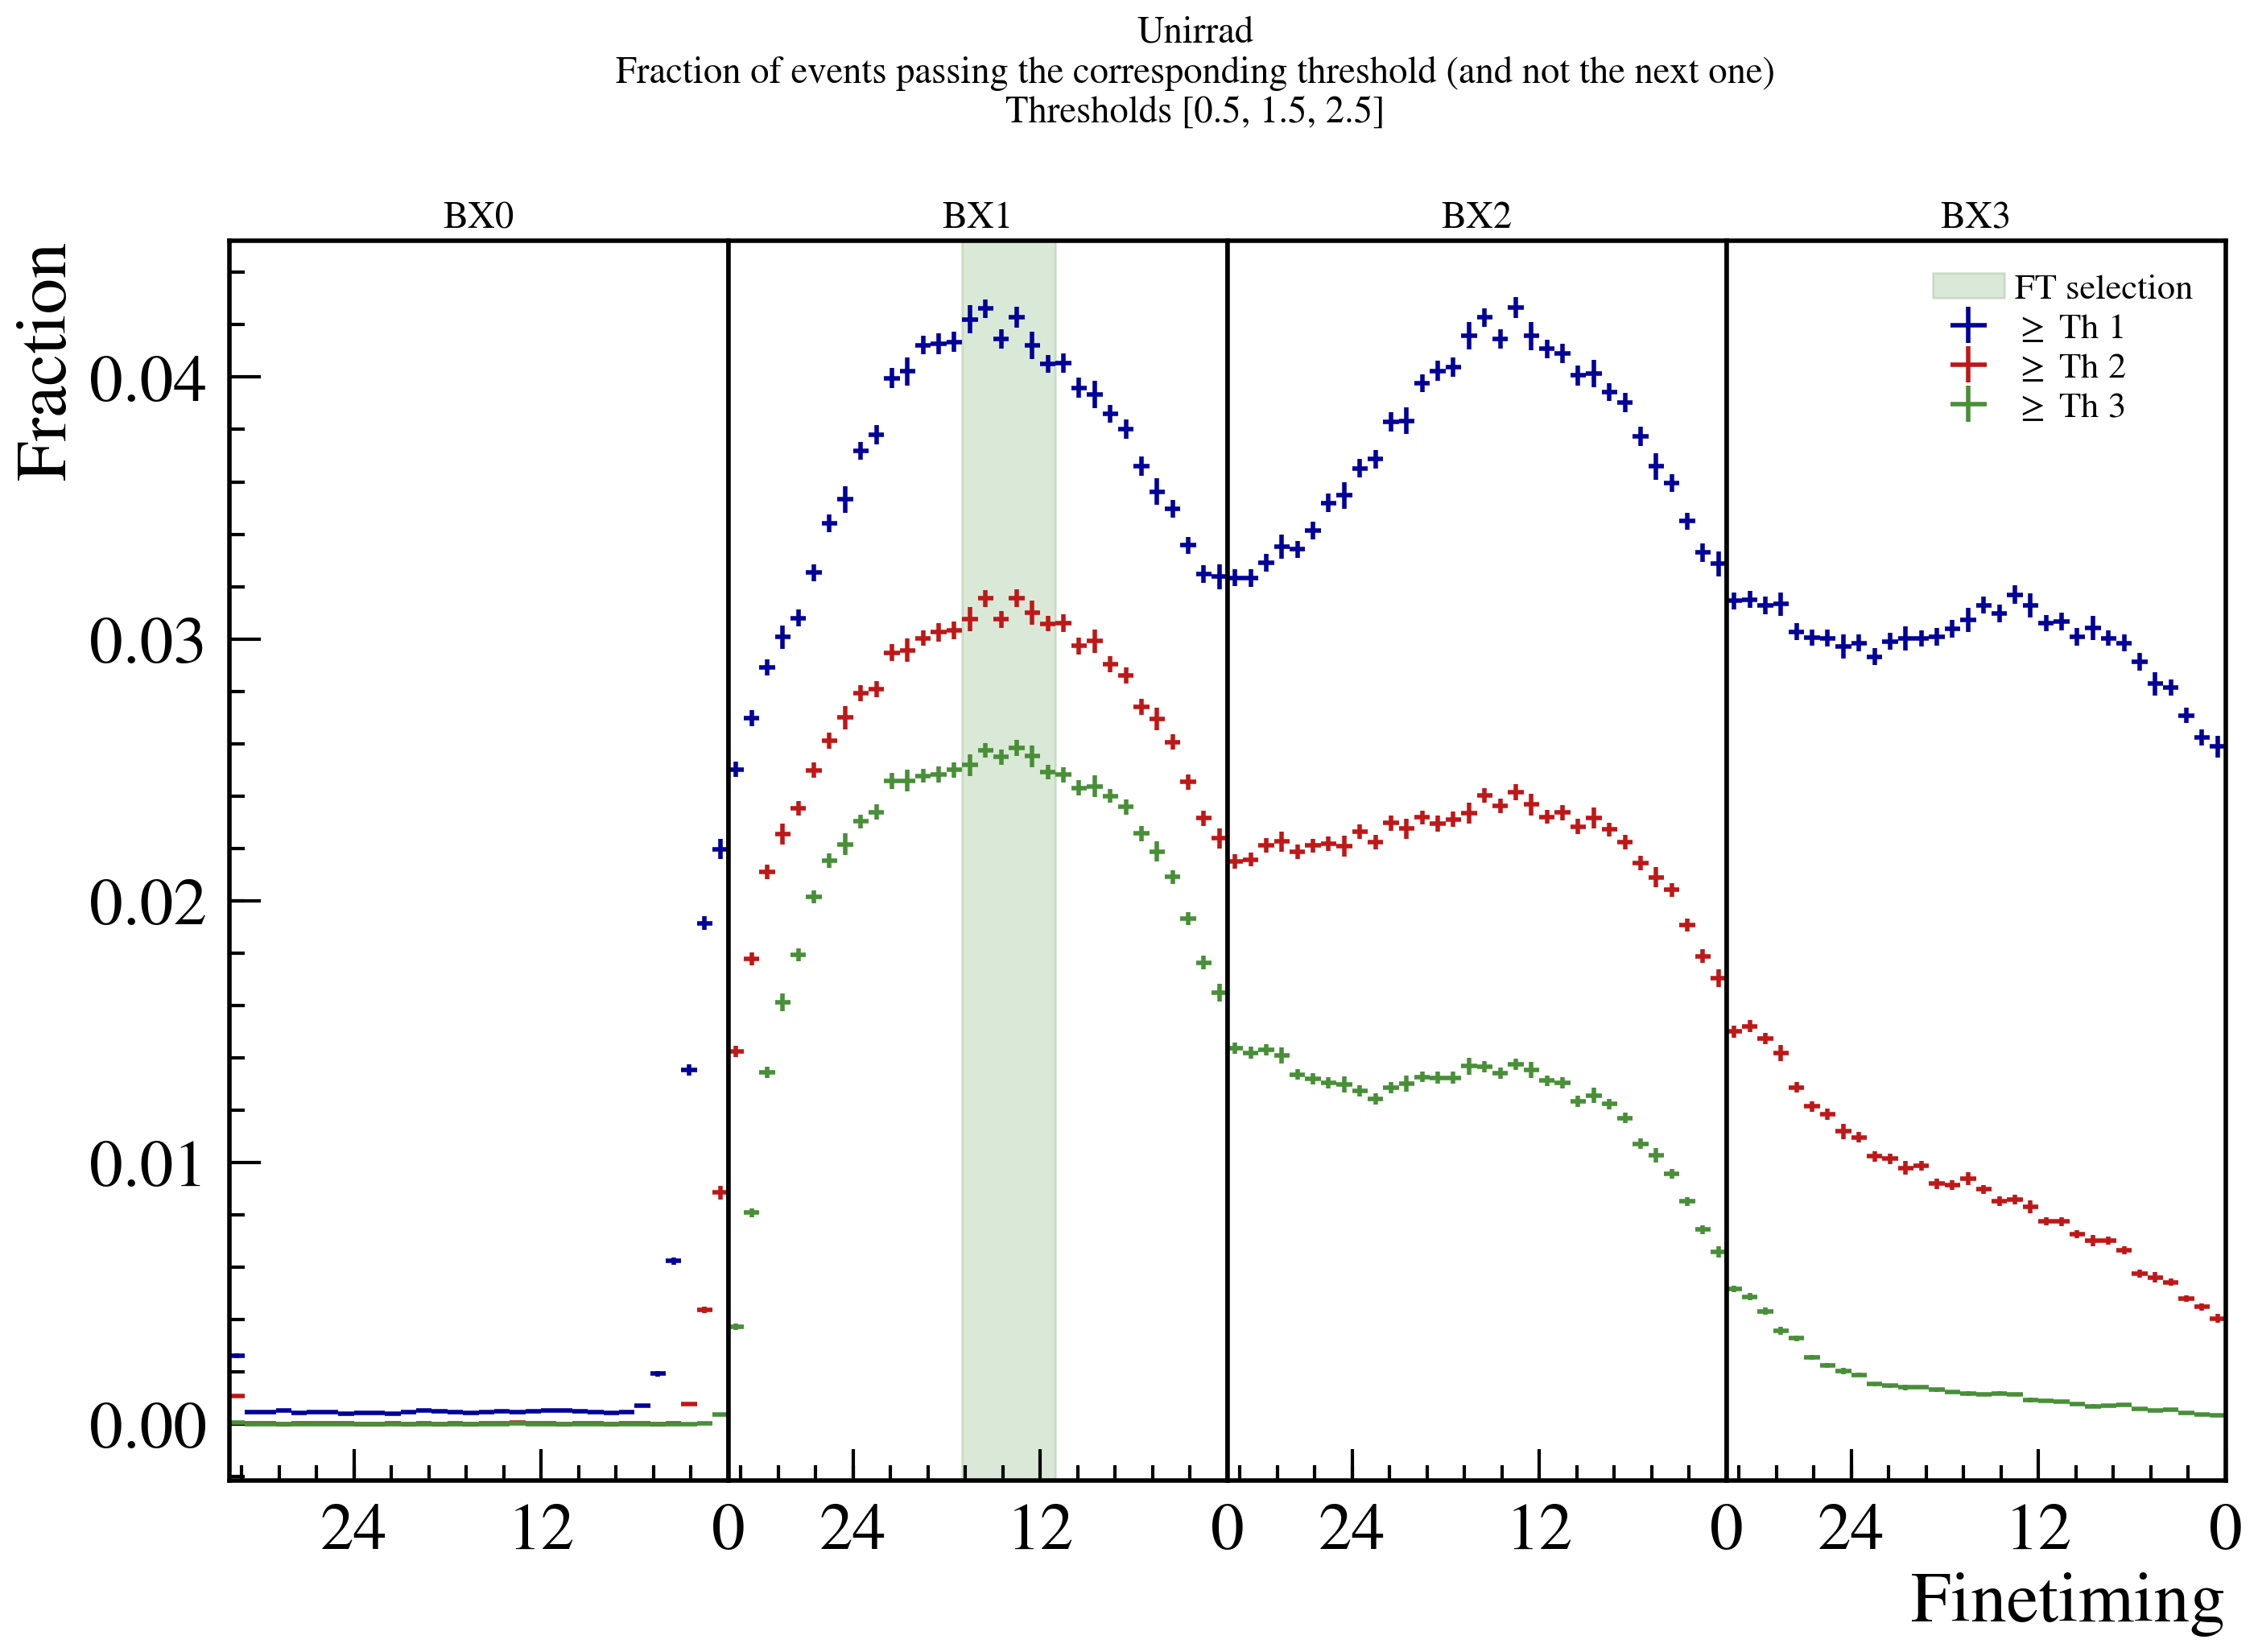

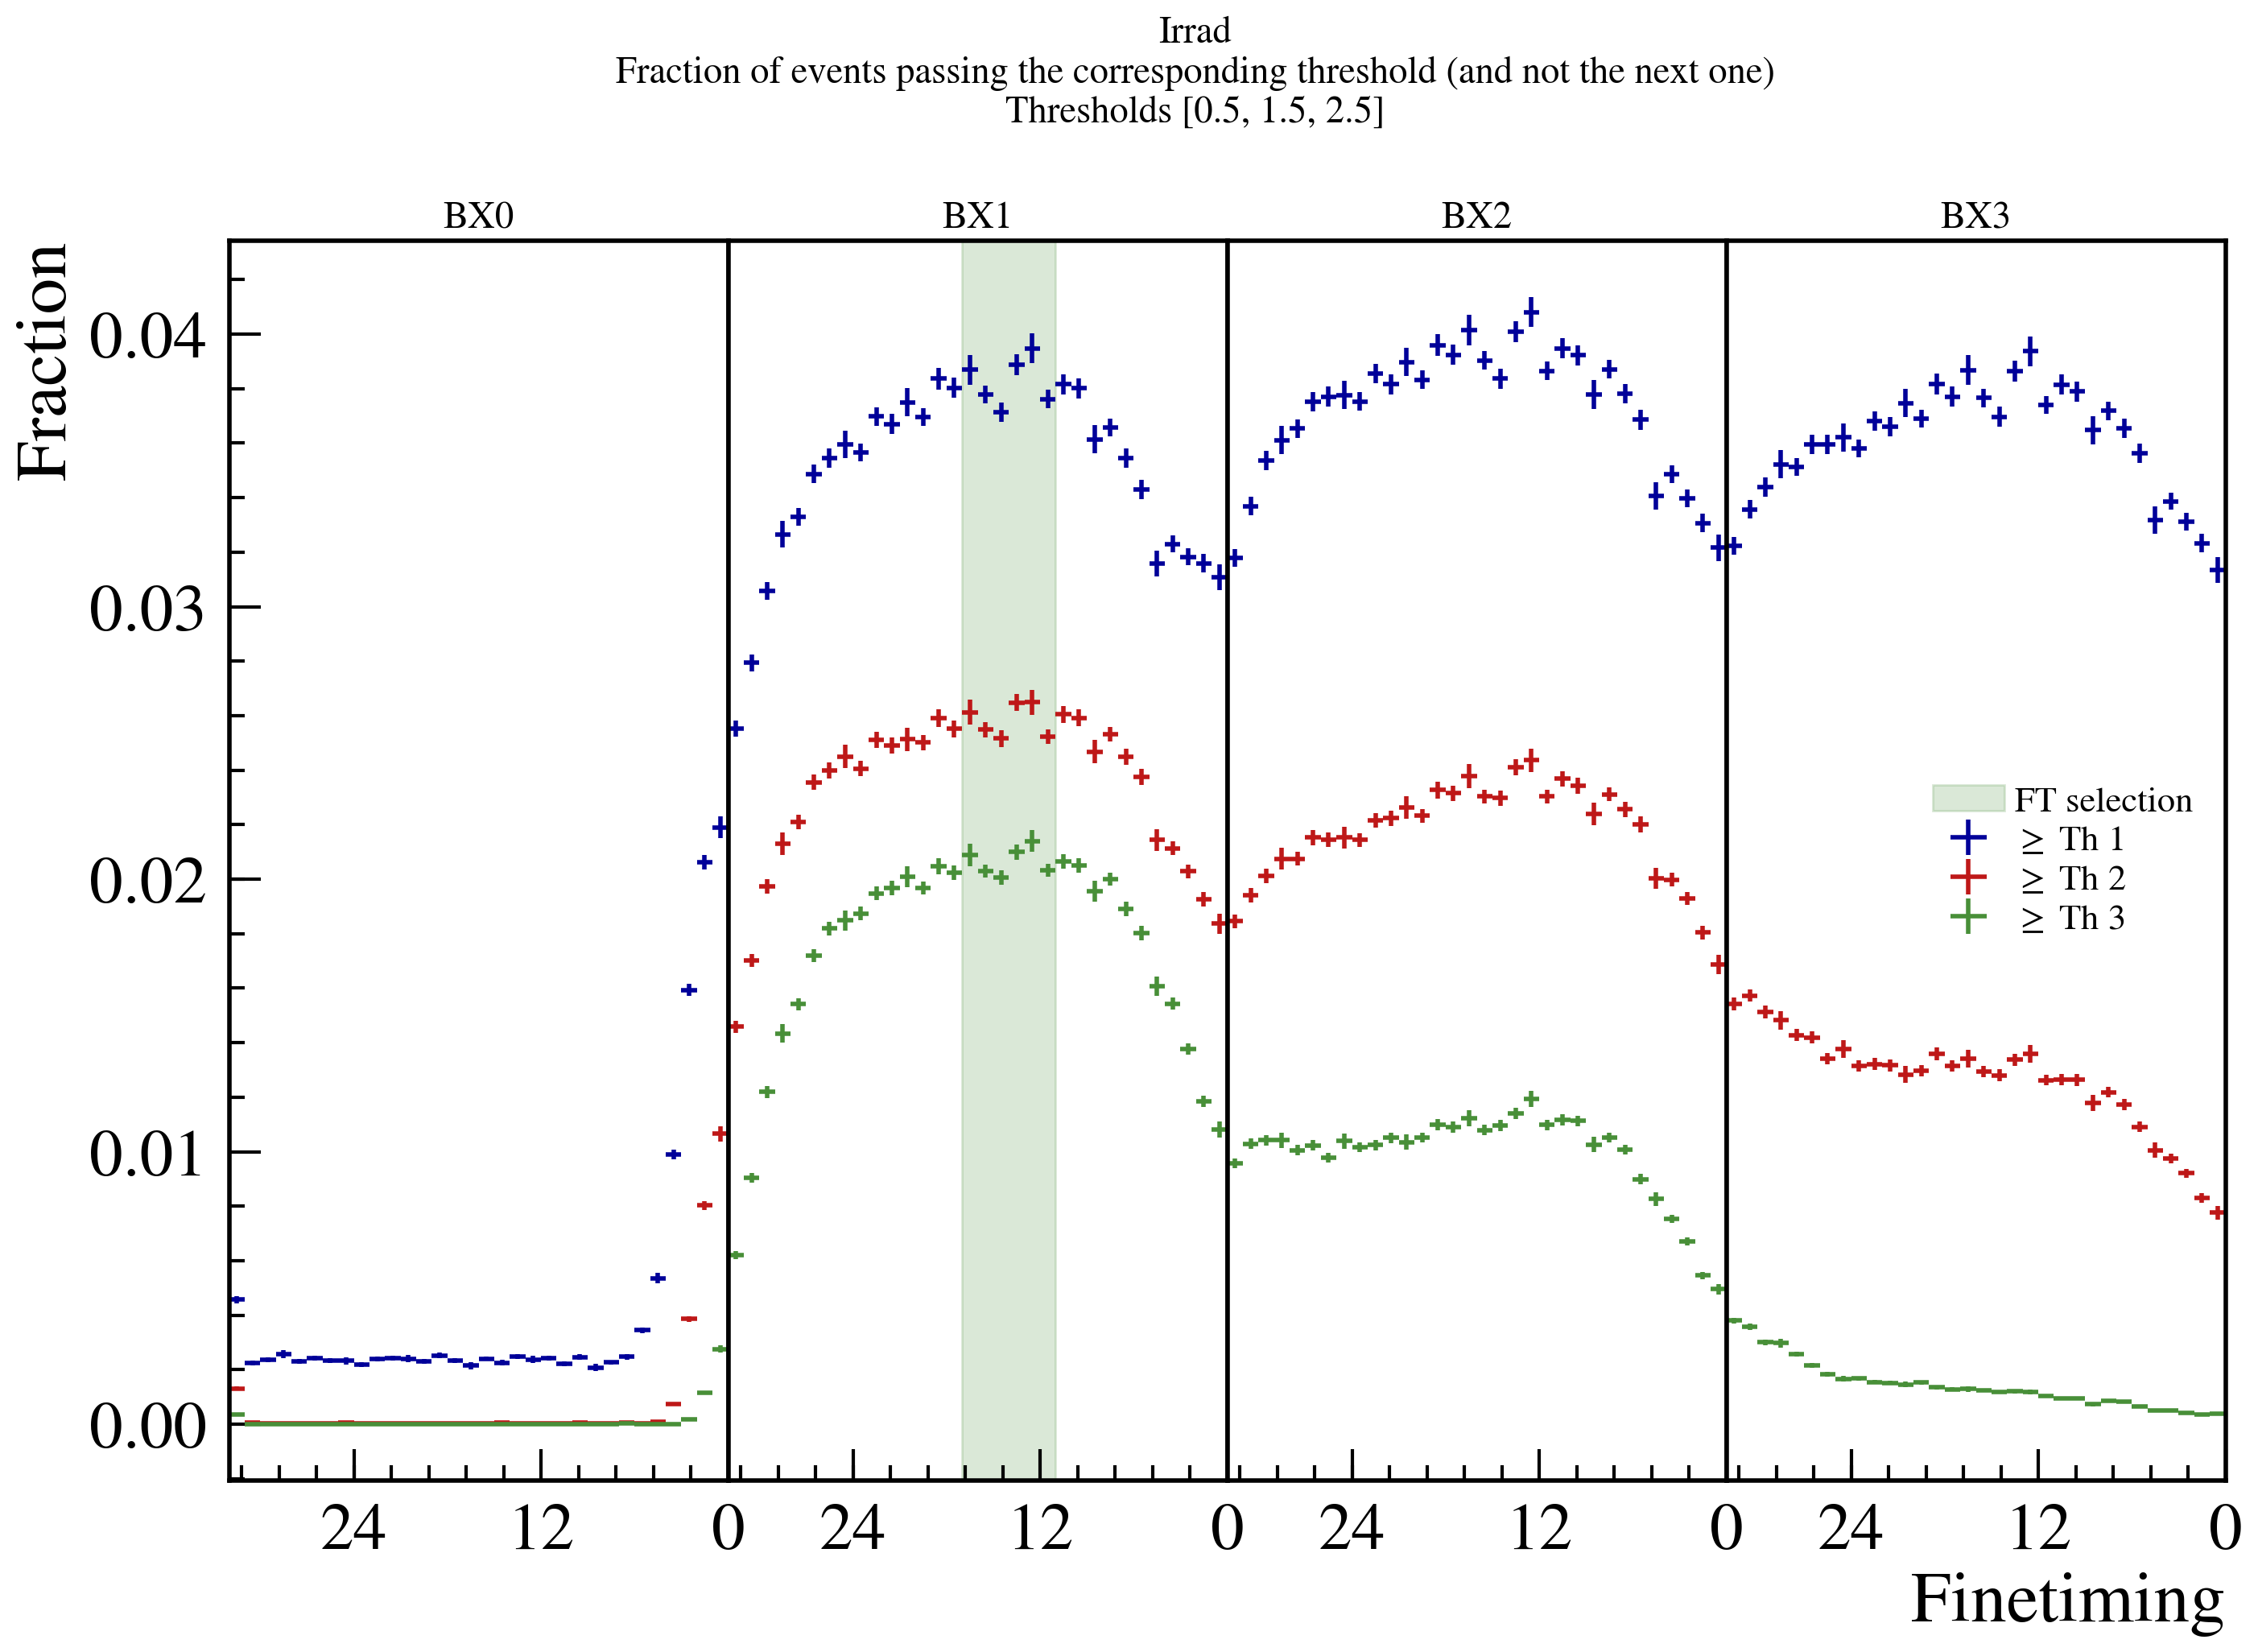

In [98]:
channels = range(64)
finetiming_shift = 2

for module, DF in izip(["Unirrad", "Irrad"], [DF_unirrad, DF_irrad]):
    fig, axes = TB.signalshape_new(DF["BXing"], (DF["Finetiming"]-finetiming_shift)%32, 
                                   DF[["Ch_{}".format(ch) for ch in channels]].values, 
                                   mode="geq", BXs=[0,1,2,3])
    title = module
    title += "\nFraction of events passing the corresponding threshold (and not the next one)"
    title += "\nThresholds [0.5, 1.5, 2.5]"
    fig.suptitle(title, y=1.02)
    axes[1].axvspan(13-finetiming_shift, 19-finetiming_shift, color="gcgreen", label="FT selection", alpha=0.2)
    handles, labels = axes[1].get_legend_handles_labels()
    plt.legend(handles, labels, fontsize=16)
    plt.show()
    plt.close()

# Signalshape when cutting on channel value in certain BX

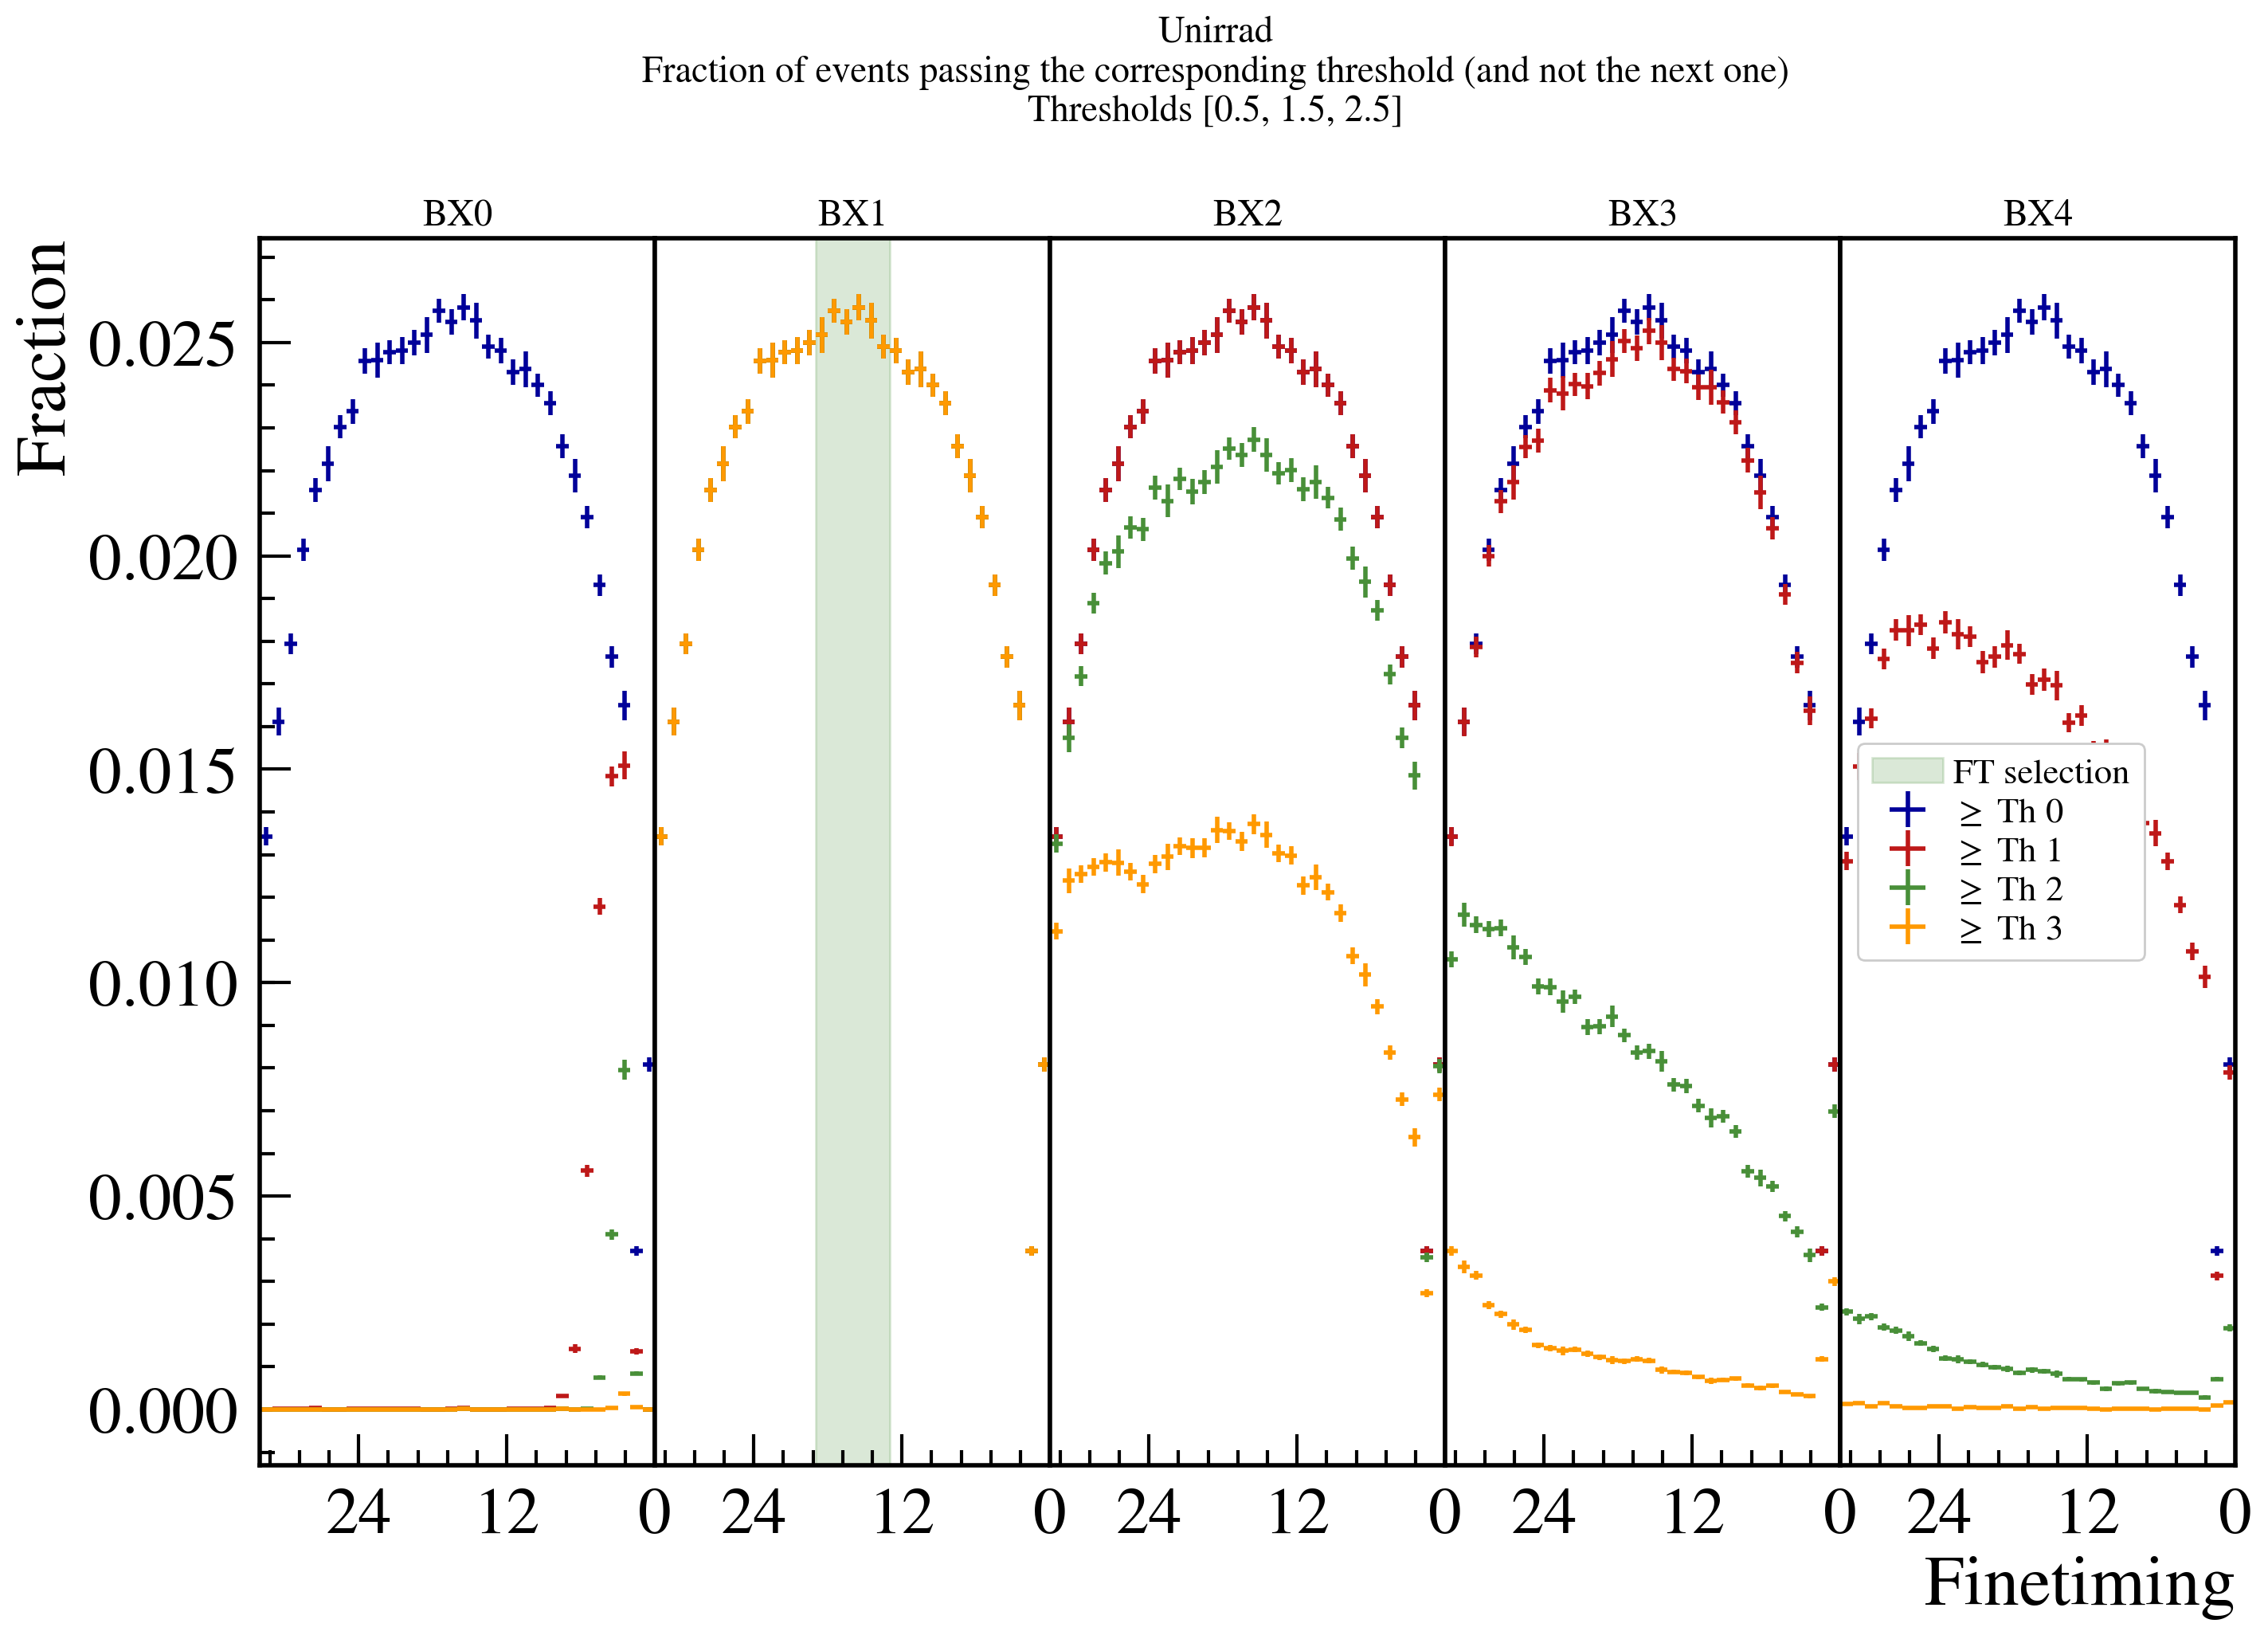

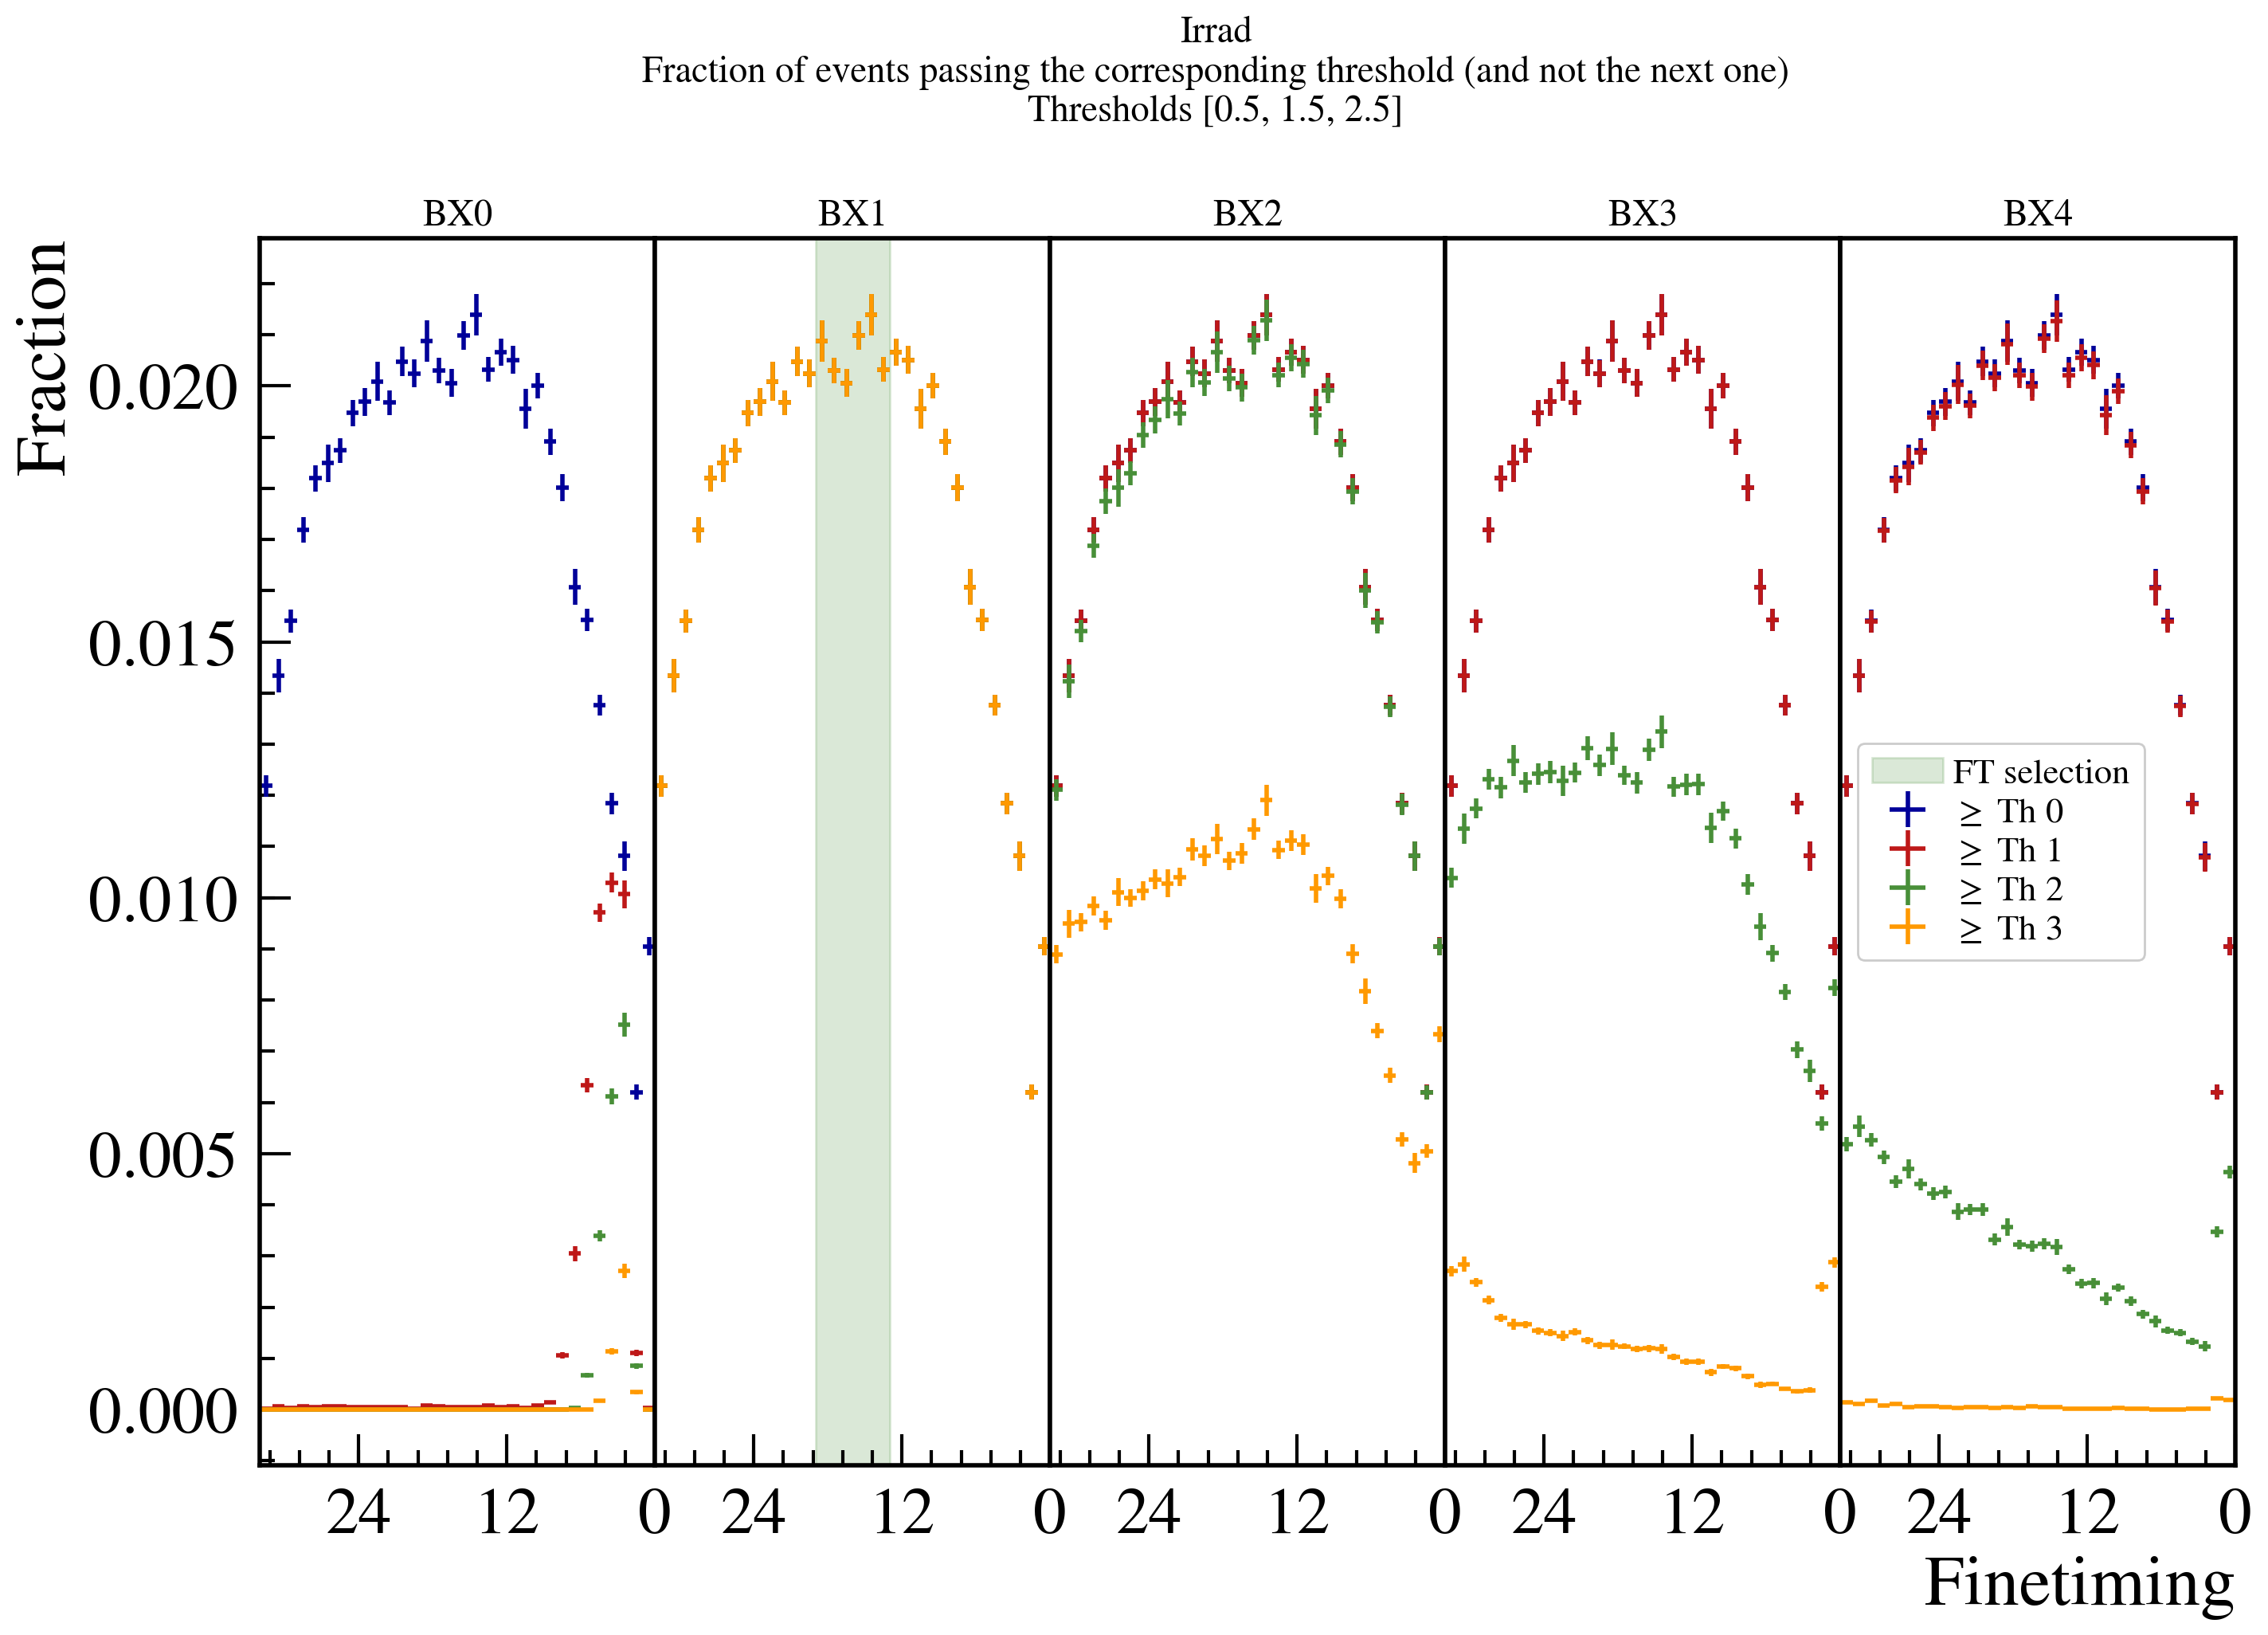

In [89]:
channels = range(64)

for module, DF in izip(["Unirrad", "Irrad"], [DF_unirrad, DF_irrad]):
    fig, axes = signalshape_new_mod(DF["BXing"], DF["Finetiming"], DF[["Ch_{}".format(ch) for ch in channels]].values, 
                                   mode="geq", BXs=range(5), cut_BX_val=[1, 3], Ths=[0,1,2,3])
    title = module
    title += "\nFraction of events passing the corresponding threshold (and not the next one)"
    title += "\nThresholds [0.5, 1.5, 2.5]"
    fig.suptitle(title, y=1.02)
    axes[1].axvspan(13, 19, color="gcgreen", label="FT selection", alpha=0.2)
    handles, labels = axes[1].get_legend_handles_labels()
    plt.legend(handles, labels, fontsize=16, frameon=True, framealpha=1)
    plt.show()
    plt.close()

# Plot SPIROC datarun spectrum

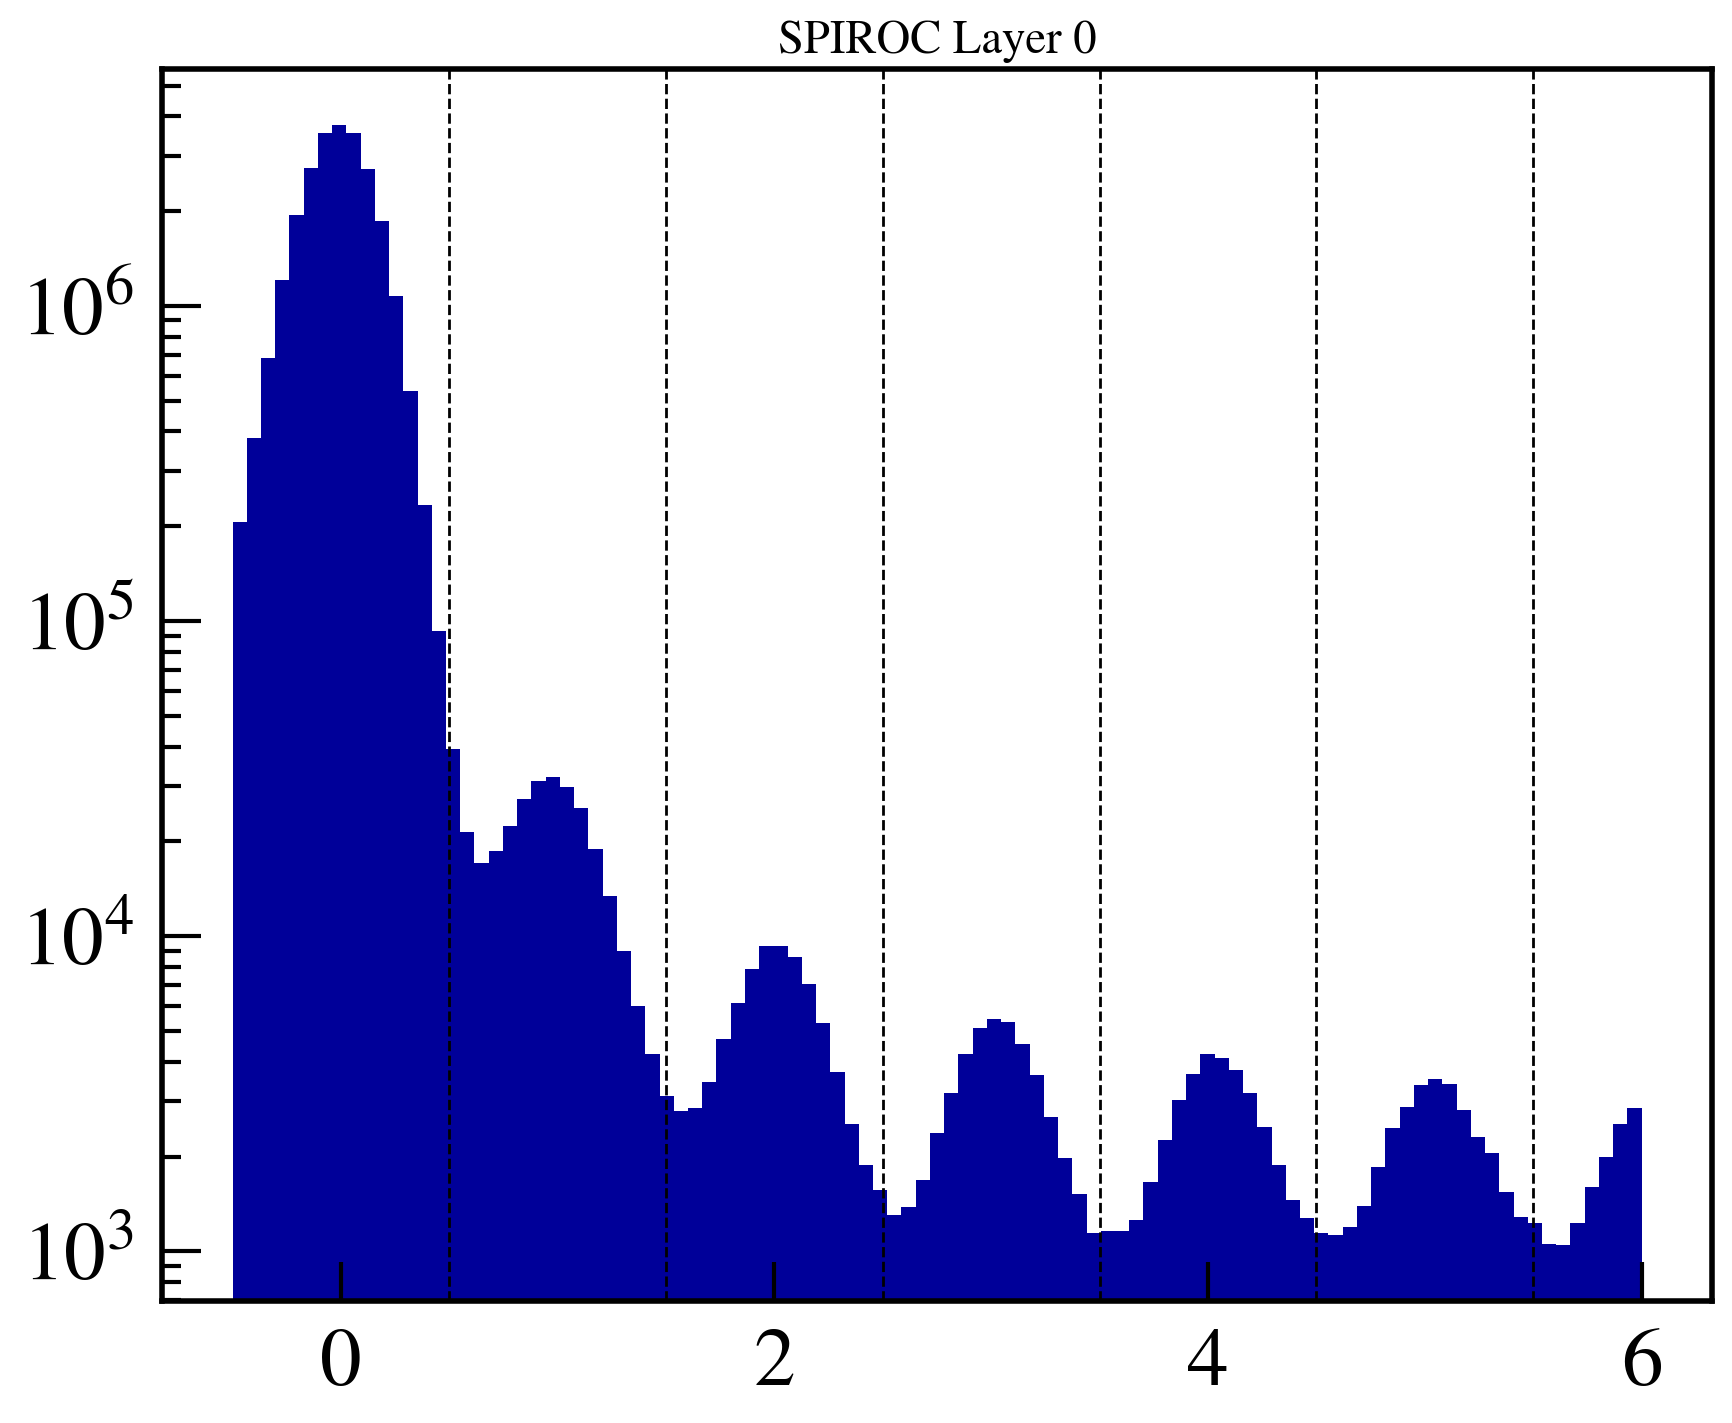

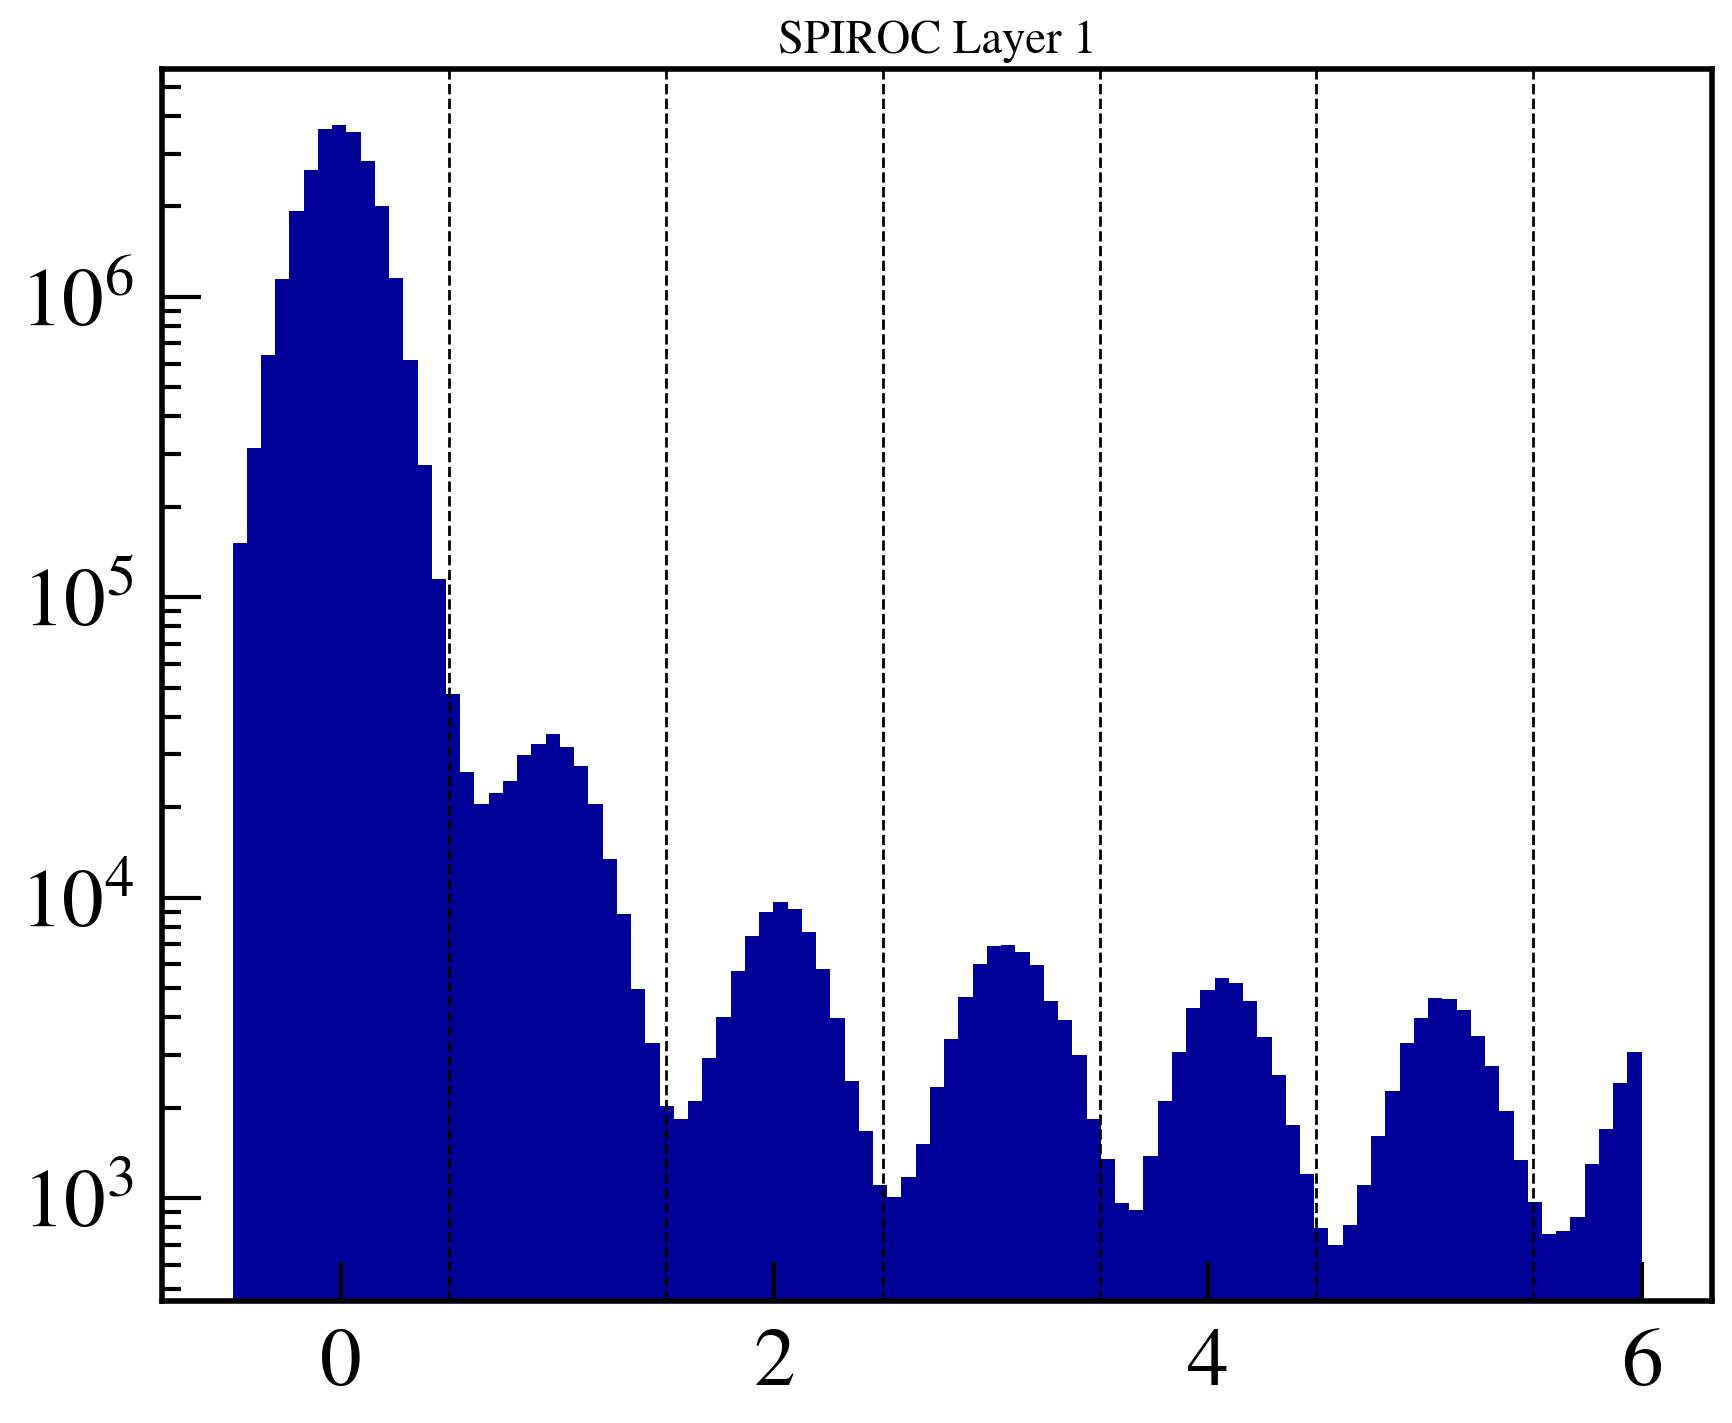

In [117]:
branches = ["Ch_{}".format(ch) for ch in range(256, 384)]
for layer, DF in enumerate([DF_SPIROC_unirrad[branches], DF_SPIROC_irrad[branches]]):
    plt.hist(DF.values.flatten(), bins=np.linspace(-0.5, 6, 100), log=True)
    plt.title("SPIROC Layer {}".format(layer))
    for x in np.arange(0.5, 6, 1):
        plt.axvline(x, color="k", ls="--", lw=1)
    plt.show()
    plt.close()

# PACIFIC Finetiming selection

In [120]:
DF_unirrad_sel = DF_unirrad.query("Finetiming >= 13 and Finetiming <= 19 and BXing == 1")
evts_before = len(DF_unirrad)
evts_after = len(DF_unirrad_sel)
print("Layer0: {} events out of {} survive selection ({:.2%})".format(evts_after, evts_before, evts_after/evts_before))

DF_irrad_sel = DF_irrad.query("Finetiming >= 13 and Finetiming <= 19 and BXing == 1")
evts_before = len(DF_irrad)
evts_after = len(DF_irrad_sel)
print("Layer1: {} events out of {} survive selection ({:.2%})".format(evts_after, evts_before, evts_after/evts_before))

Layer0: 26979 events out of 1000000 survive selection (2.70%)
Layer1: 26803 events out of 1000000 survive selection (2.68%)


# PACIFIC Ratio plots

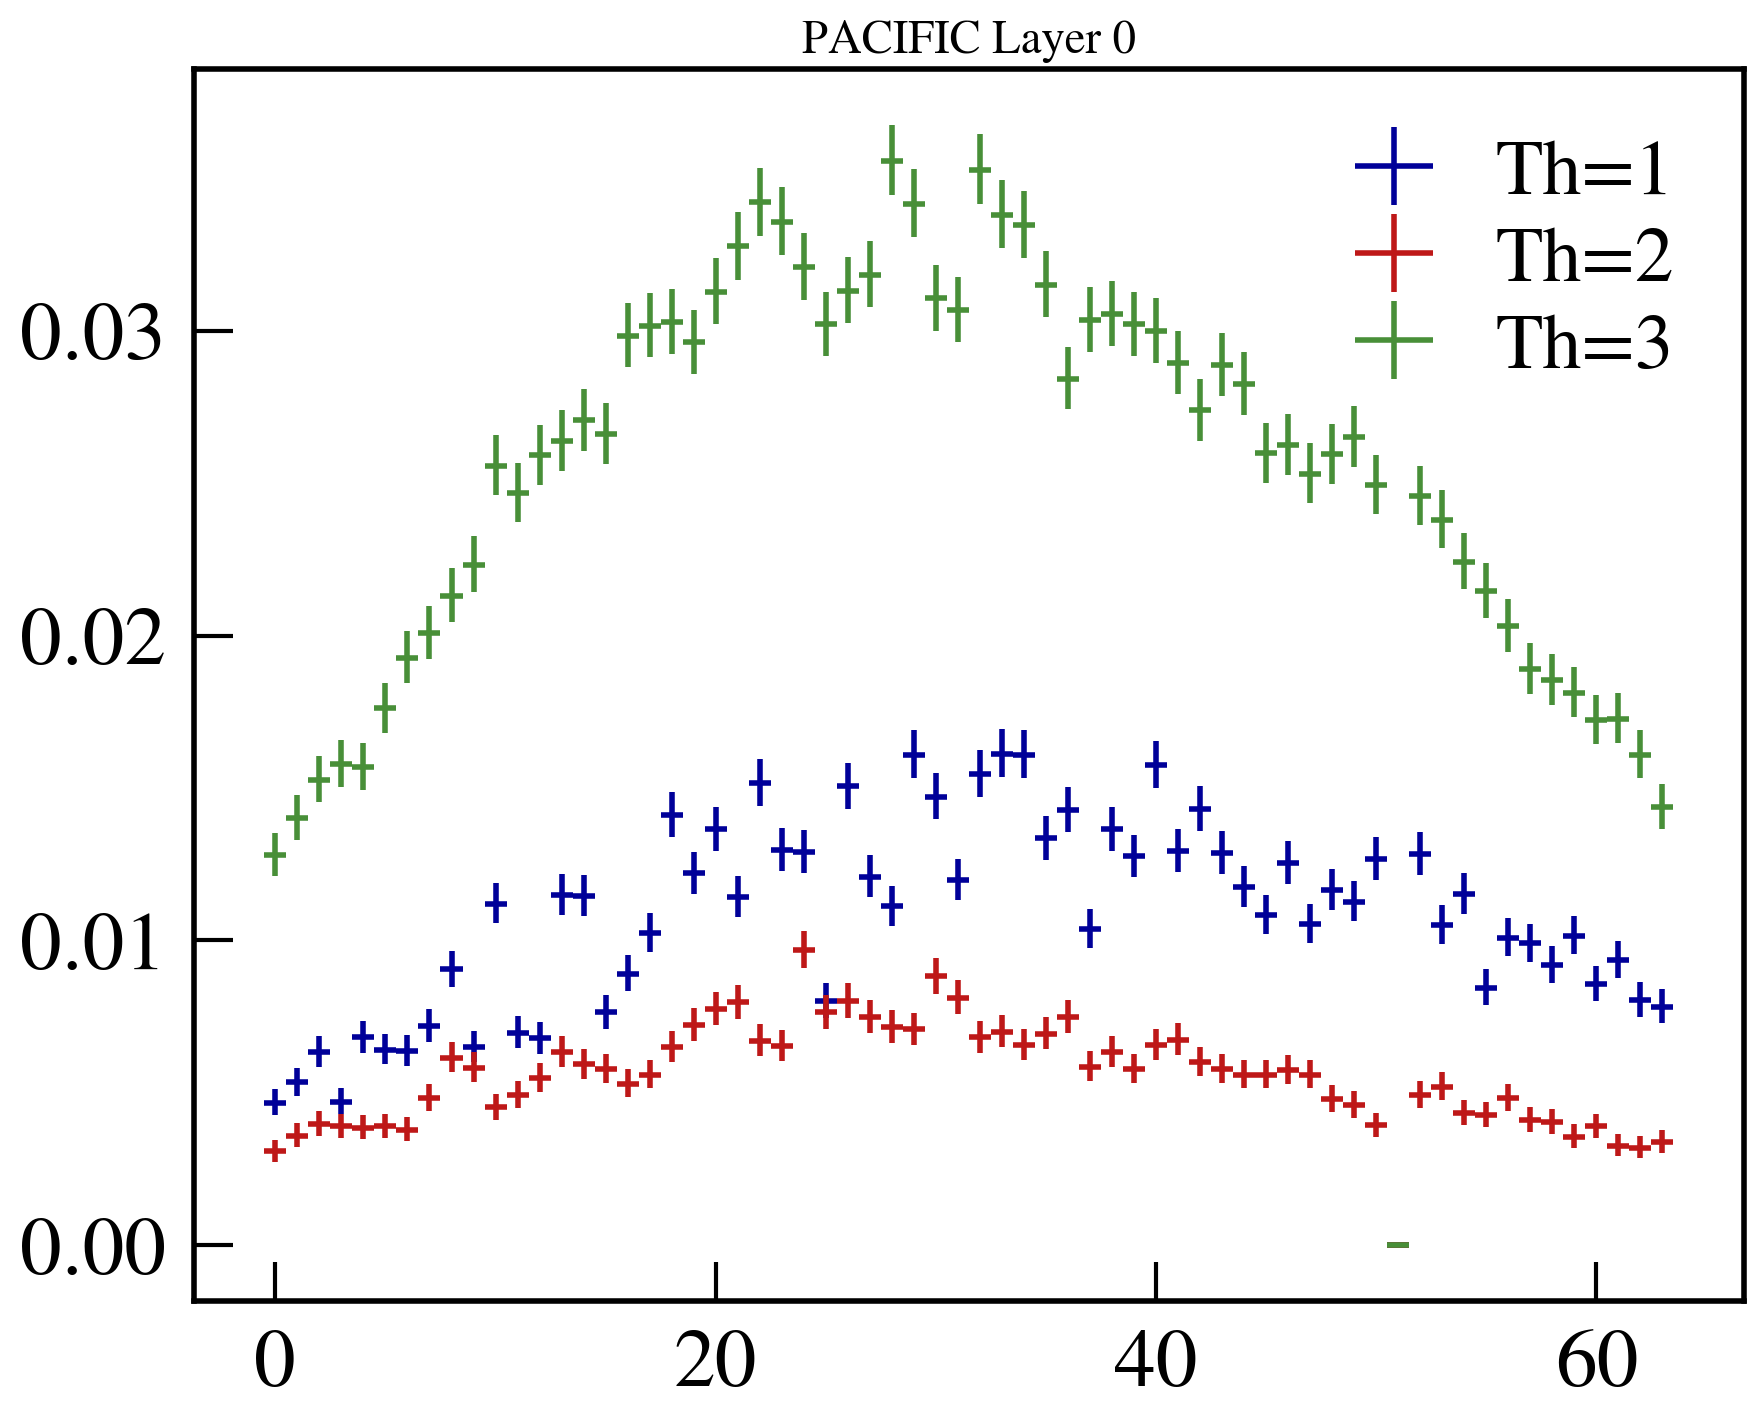

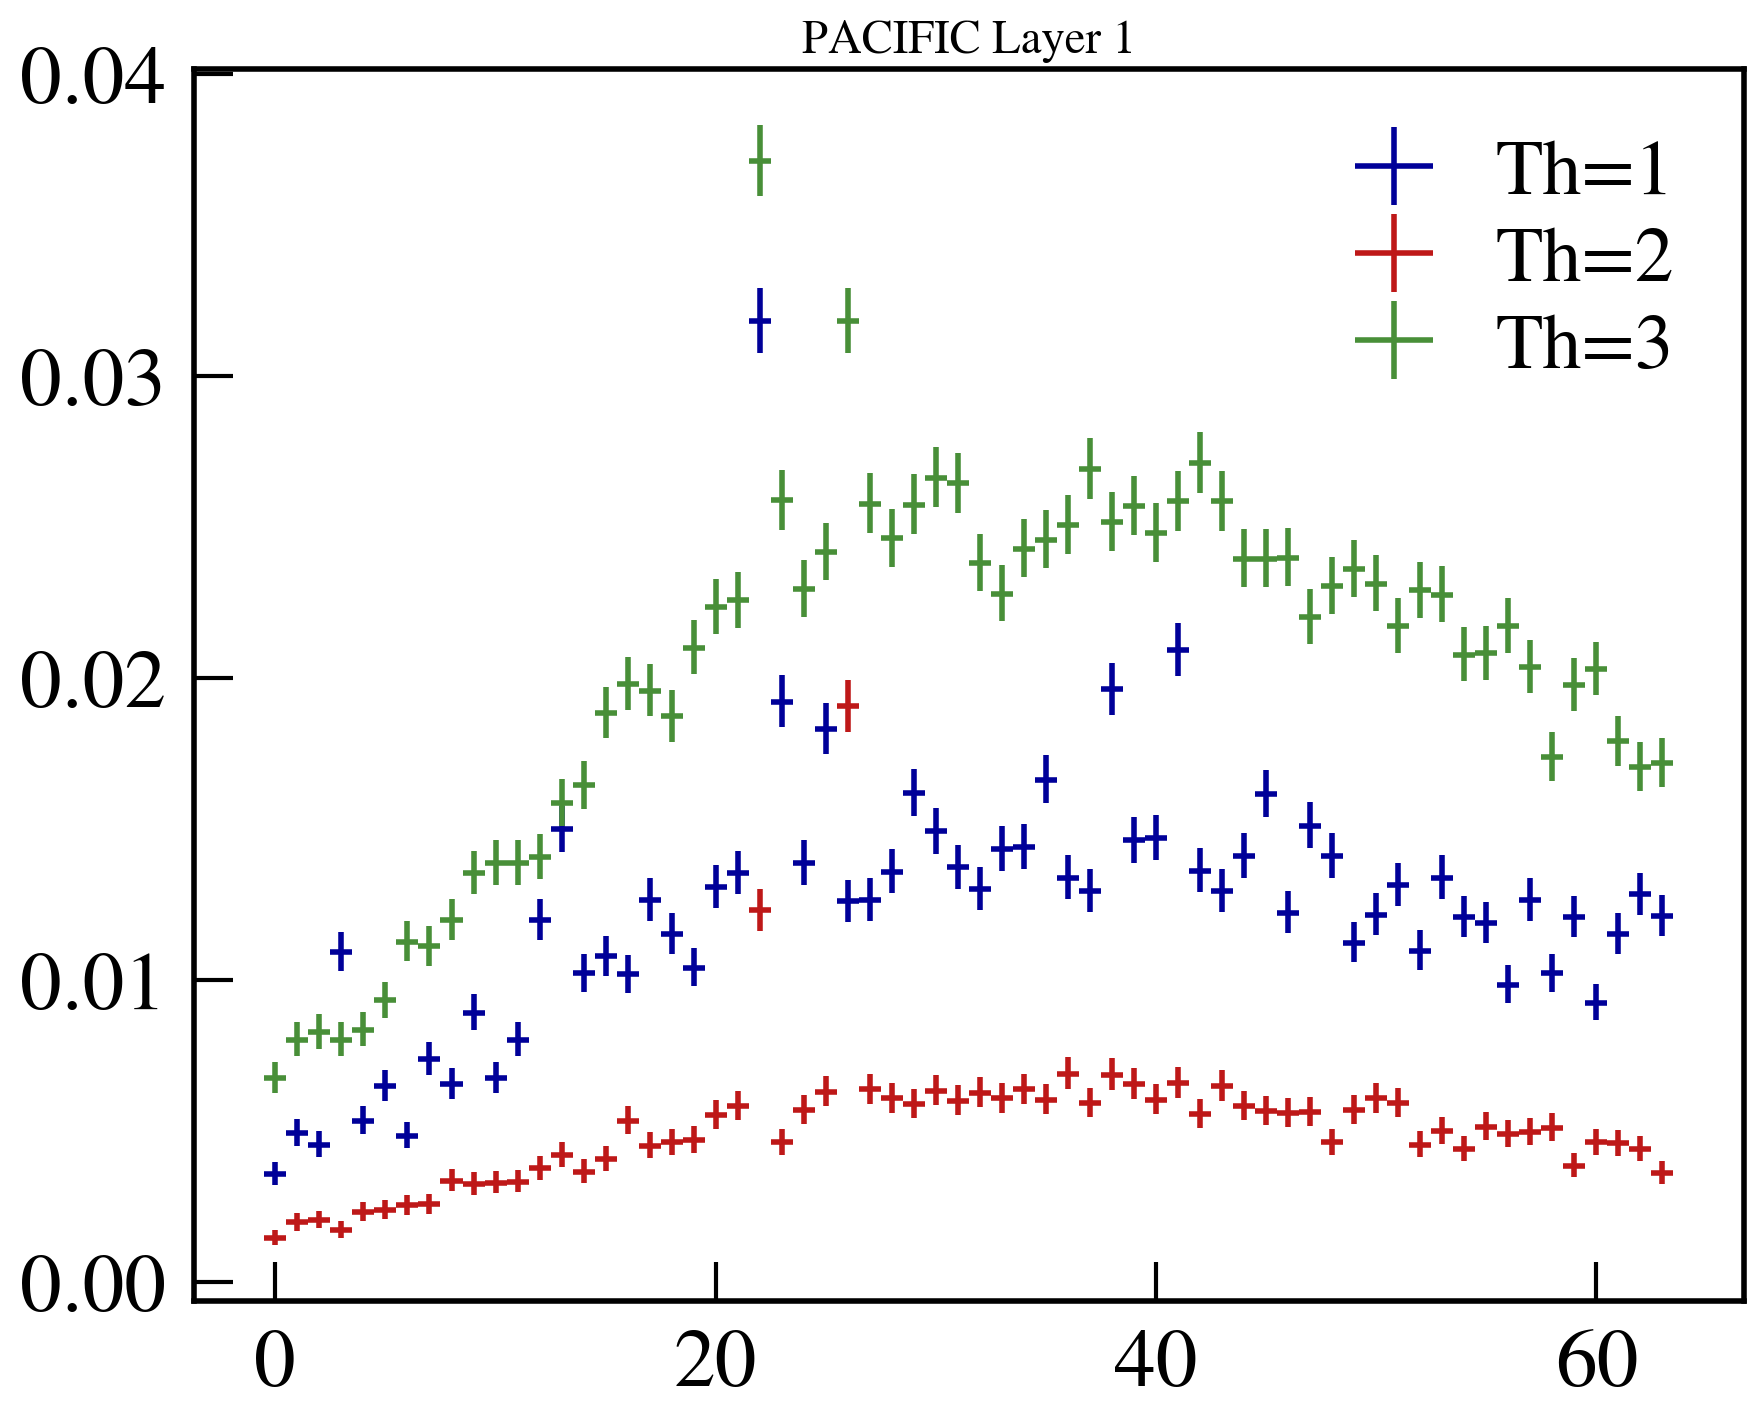

In [121]:
for layer, PACIFIC_sel in enumerate([DF_unirrad_sel, DF_irrad_sel]):
    for th in [1,2,3]:
        ratio, chs, errlow, errup = TB.overthreshold_vs_channels(
            PACIFIC_sel[["Ch_{}".format(ch) for ch in range(64)]], th, "equal")
        plt.errorbar(chs, ratio, xerr=0.5, yerr=[errlow, errup], fmt=".", ms=0, label="Th={}".format(th))
        
    plt.title("PACIFIC Layer {}".format(layer))
    plt.legend()
    plt.show()
    plt.close()

# SPIROC Ratio plots

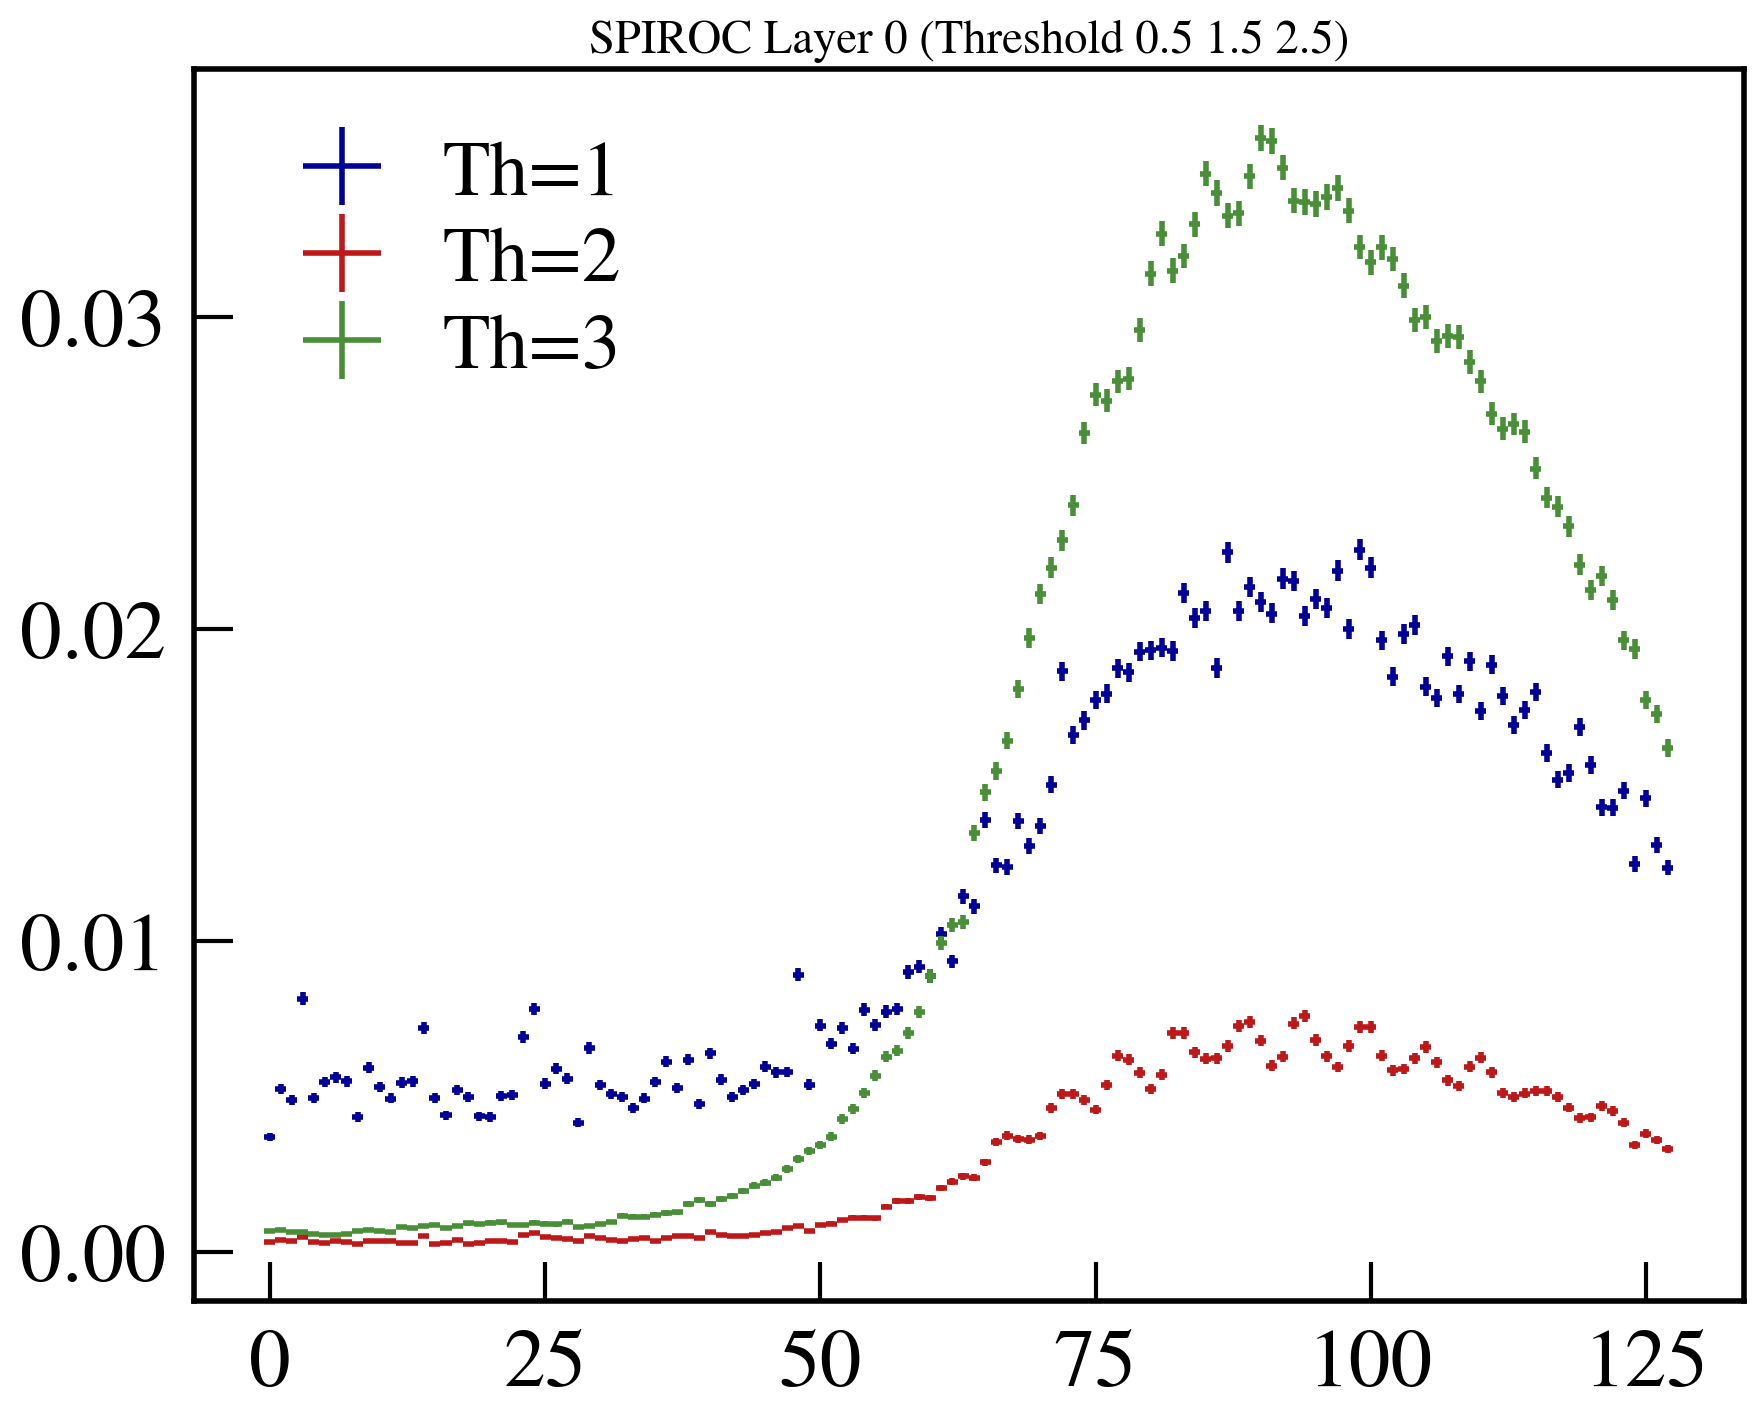

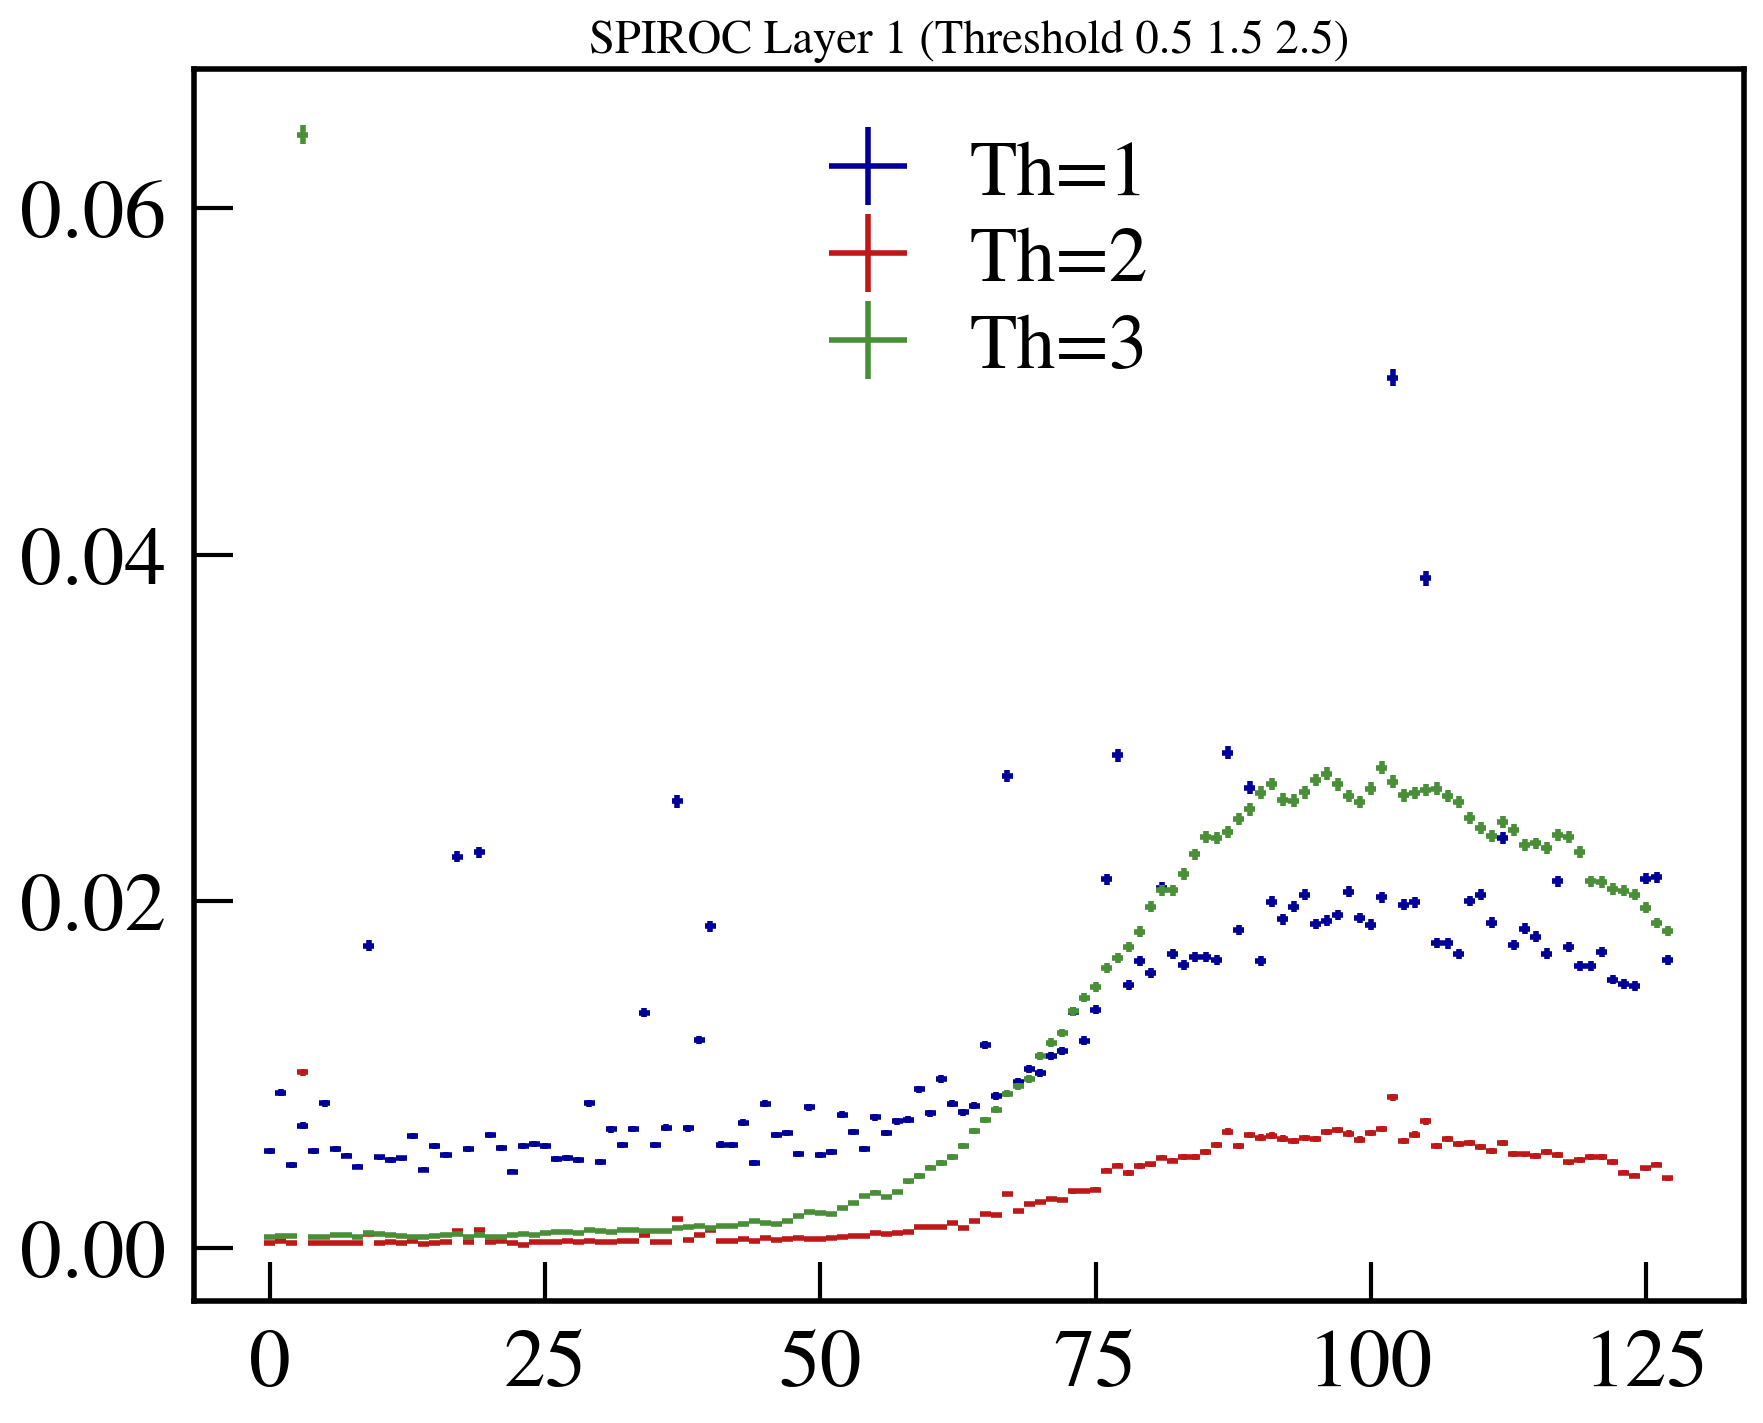

In [122]:
branches = ["Ch_{}".format(ch) for ch in range(256, 384)]
for layer, SPIROC_corr in enumerate([DF_SPIROC_unirrad, DF_SPIROC_irrad]):
    pacific_like_data = TB.SPIROC2Ths(SPIROC_corr[branches].values, Ths=[0.5, 1.5, 2.5])
    for th in [1,2,3]:
        ratio, chs, errlow, errup = TB.overthreshold_vs_channels(pacific_like_data, th, "equal")
        plt.errorbar(chs, ratio, xerr=0.5, yerr=[errlow, errup], fmt=".", ms=0, label="Th={}".format(th))
        
    plt.title("SPIROC Layer {} (Threshold {})".format(layer, "0.5 1.5 2.5"))
    plt.legend()
    plt.show()
    plt.close()

# Overlay PACIFIC and SPIROC

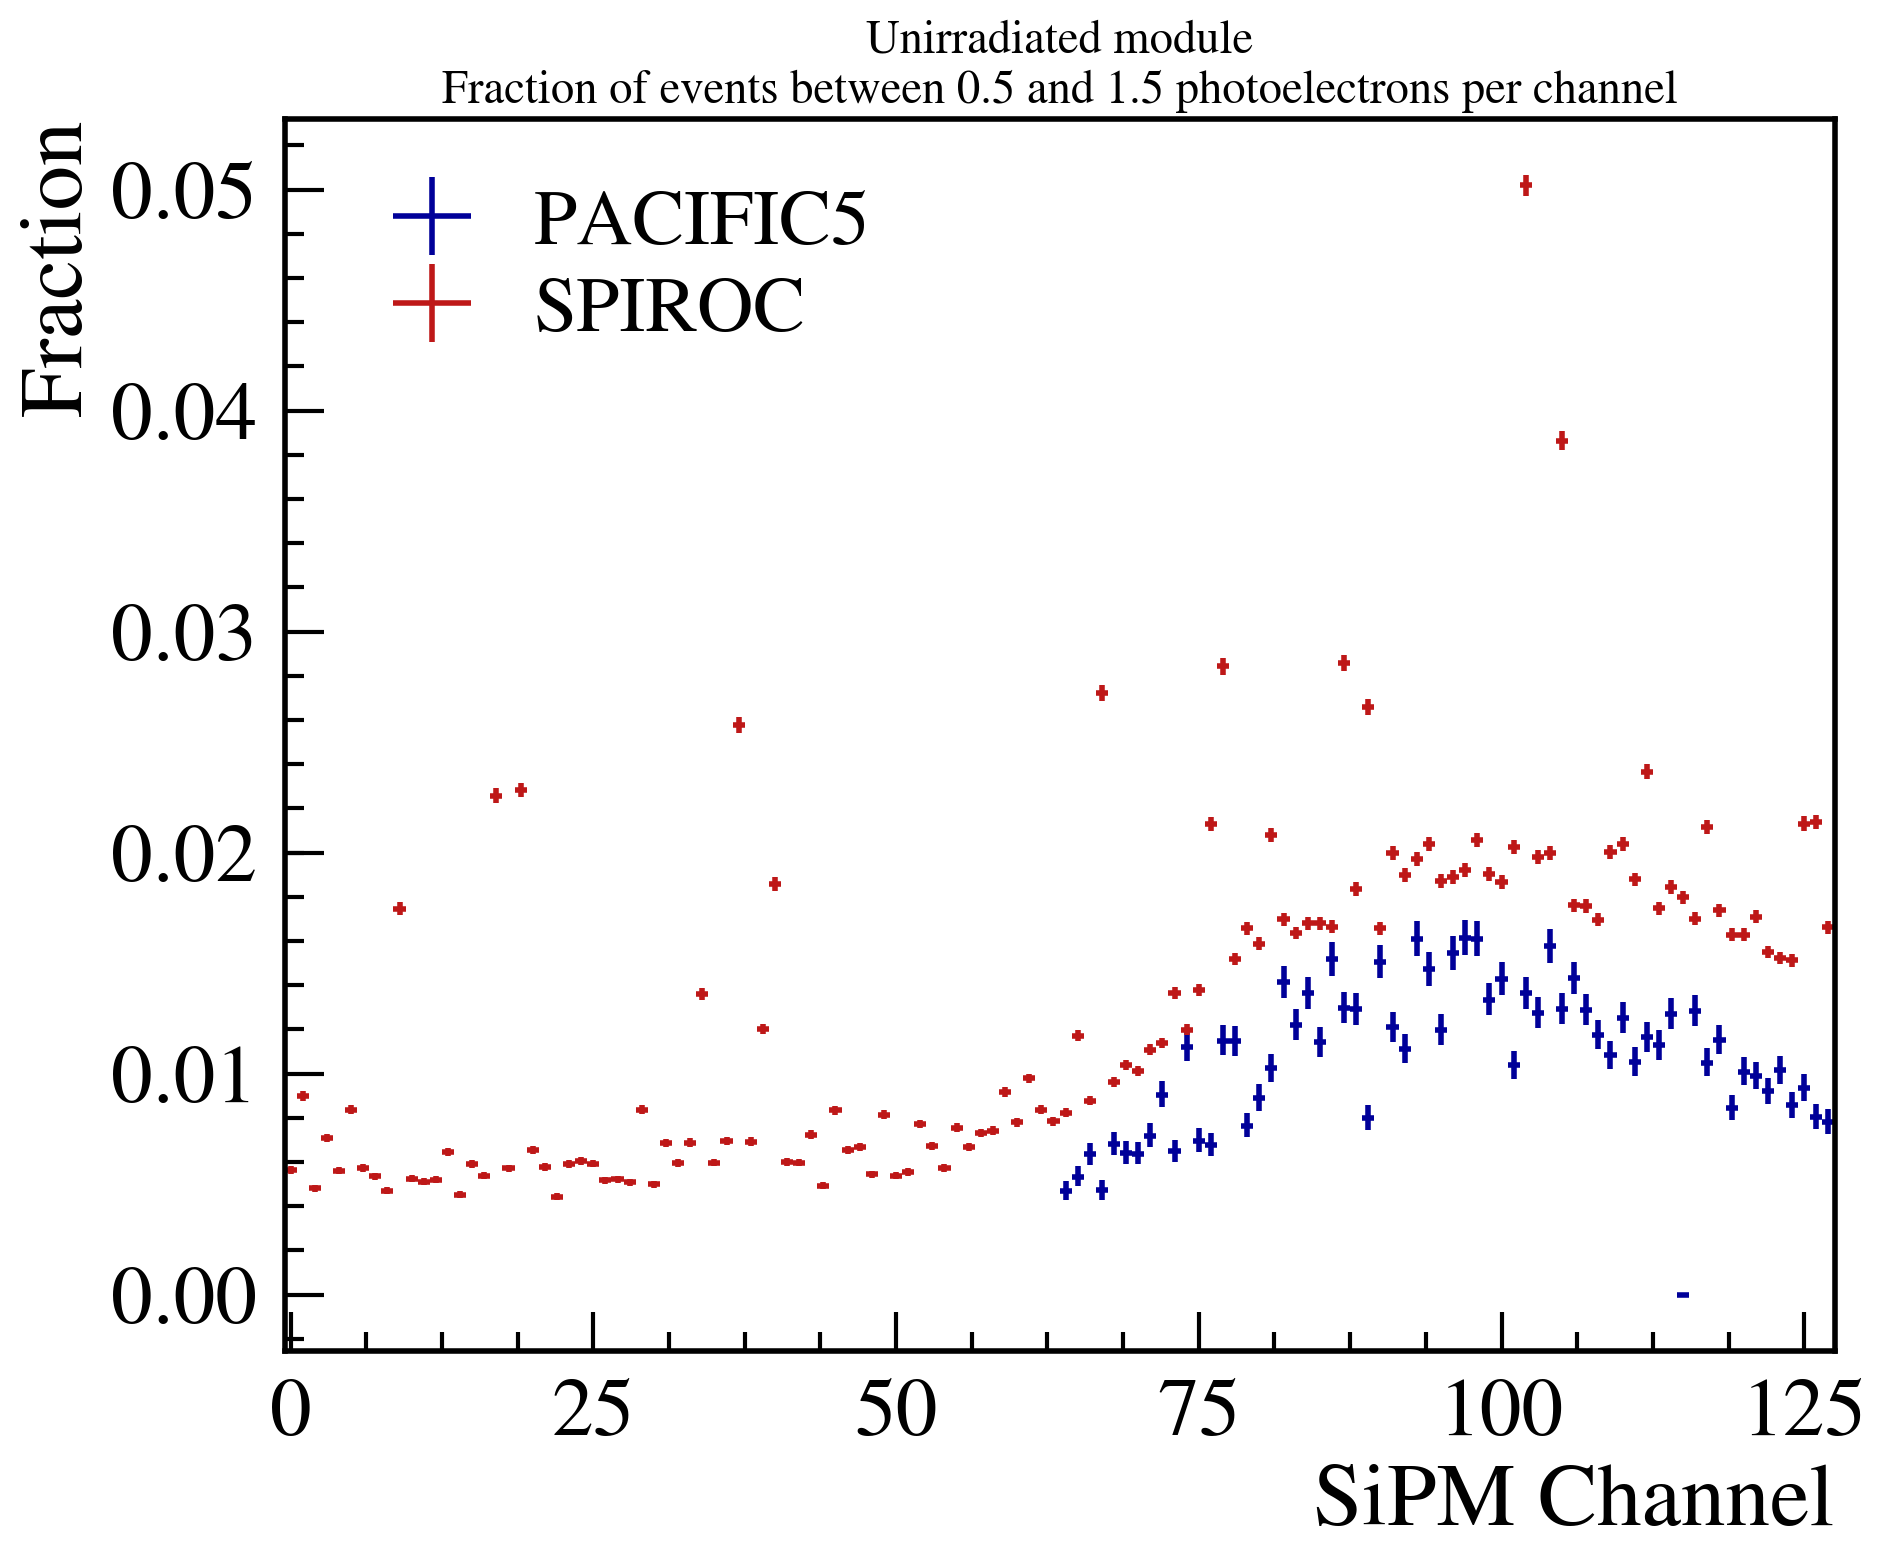

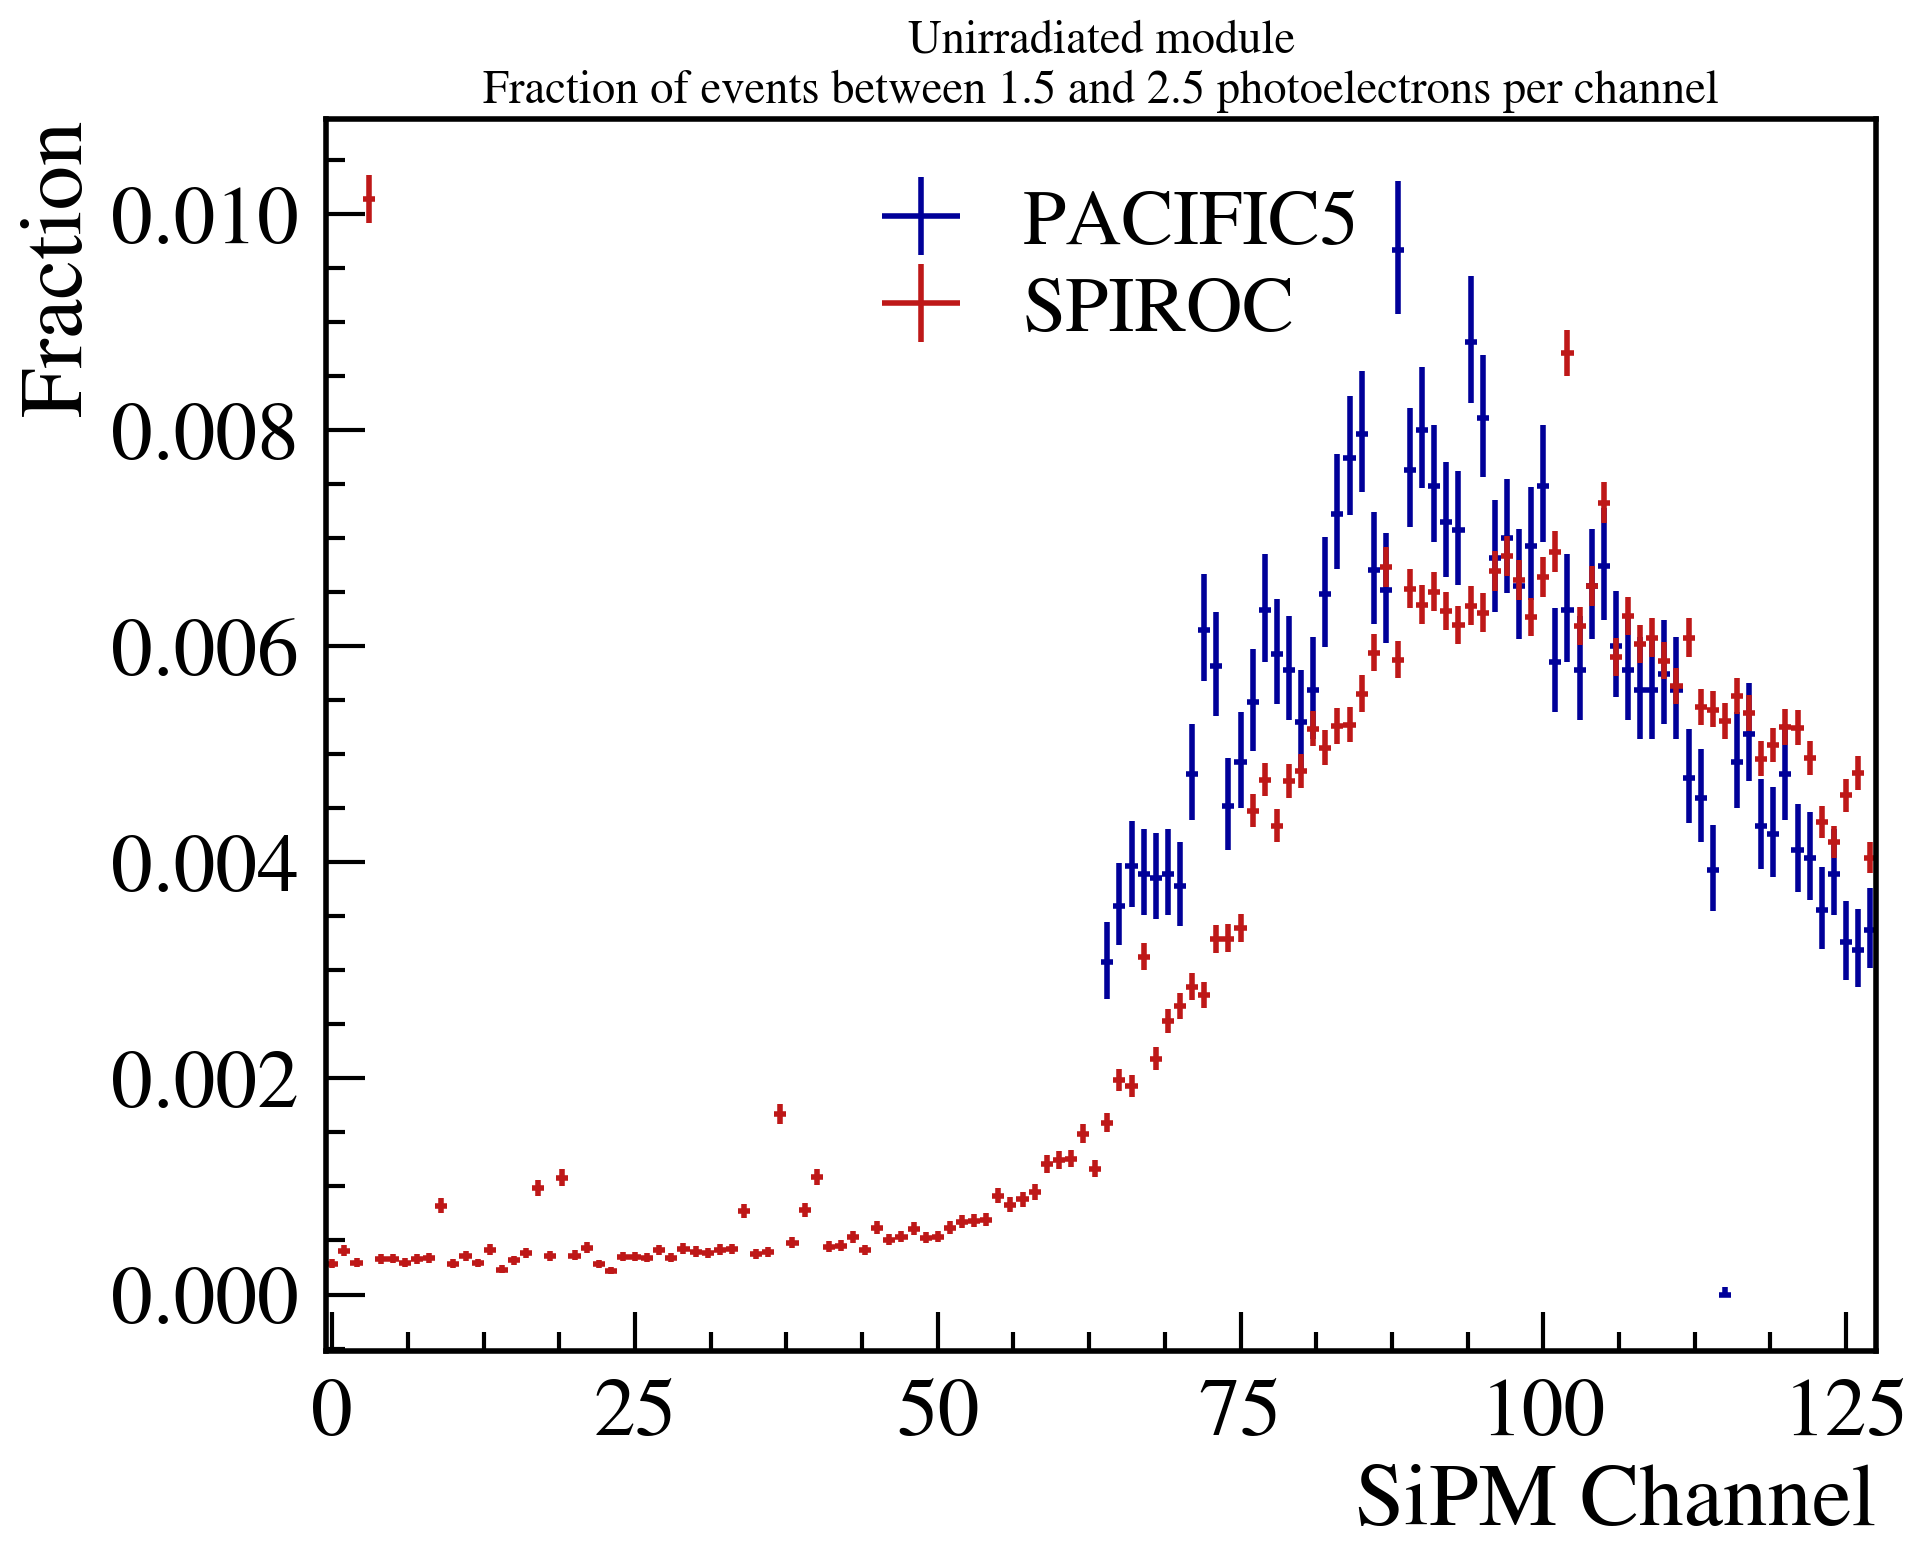

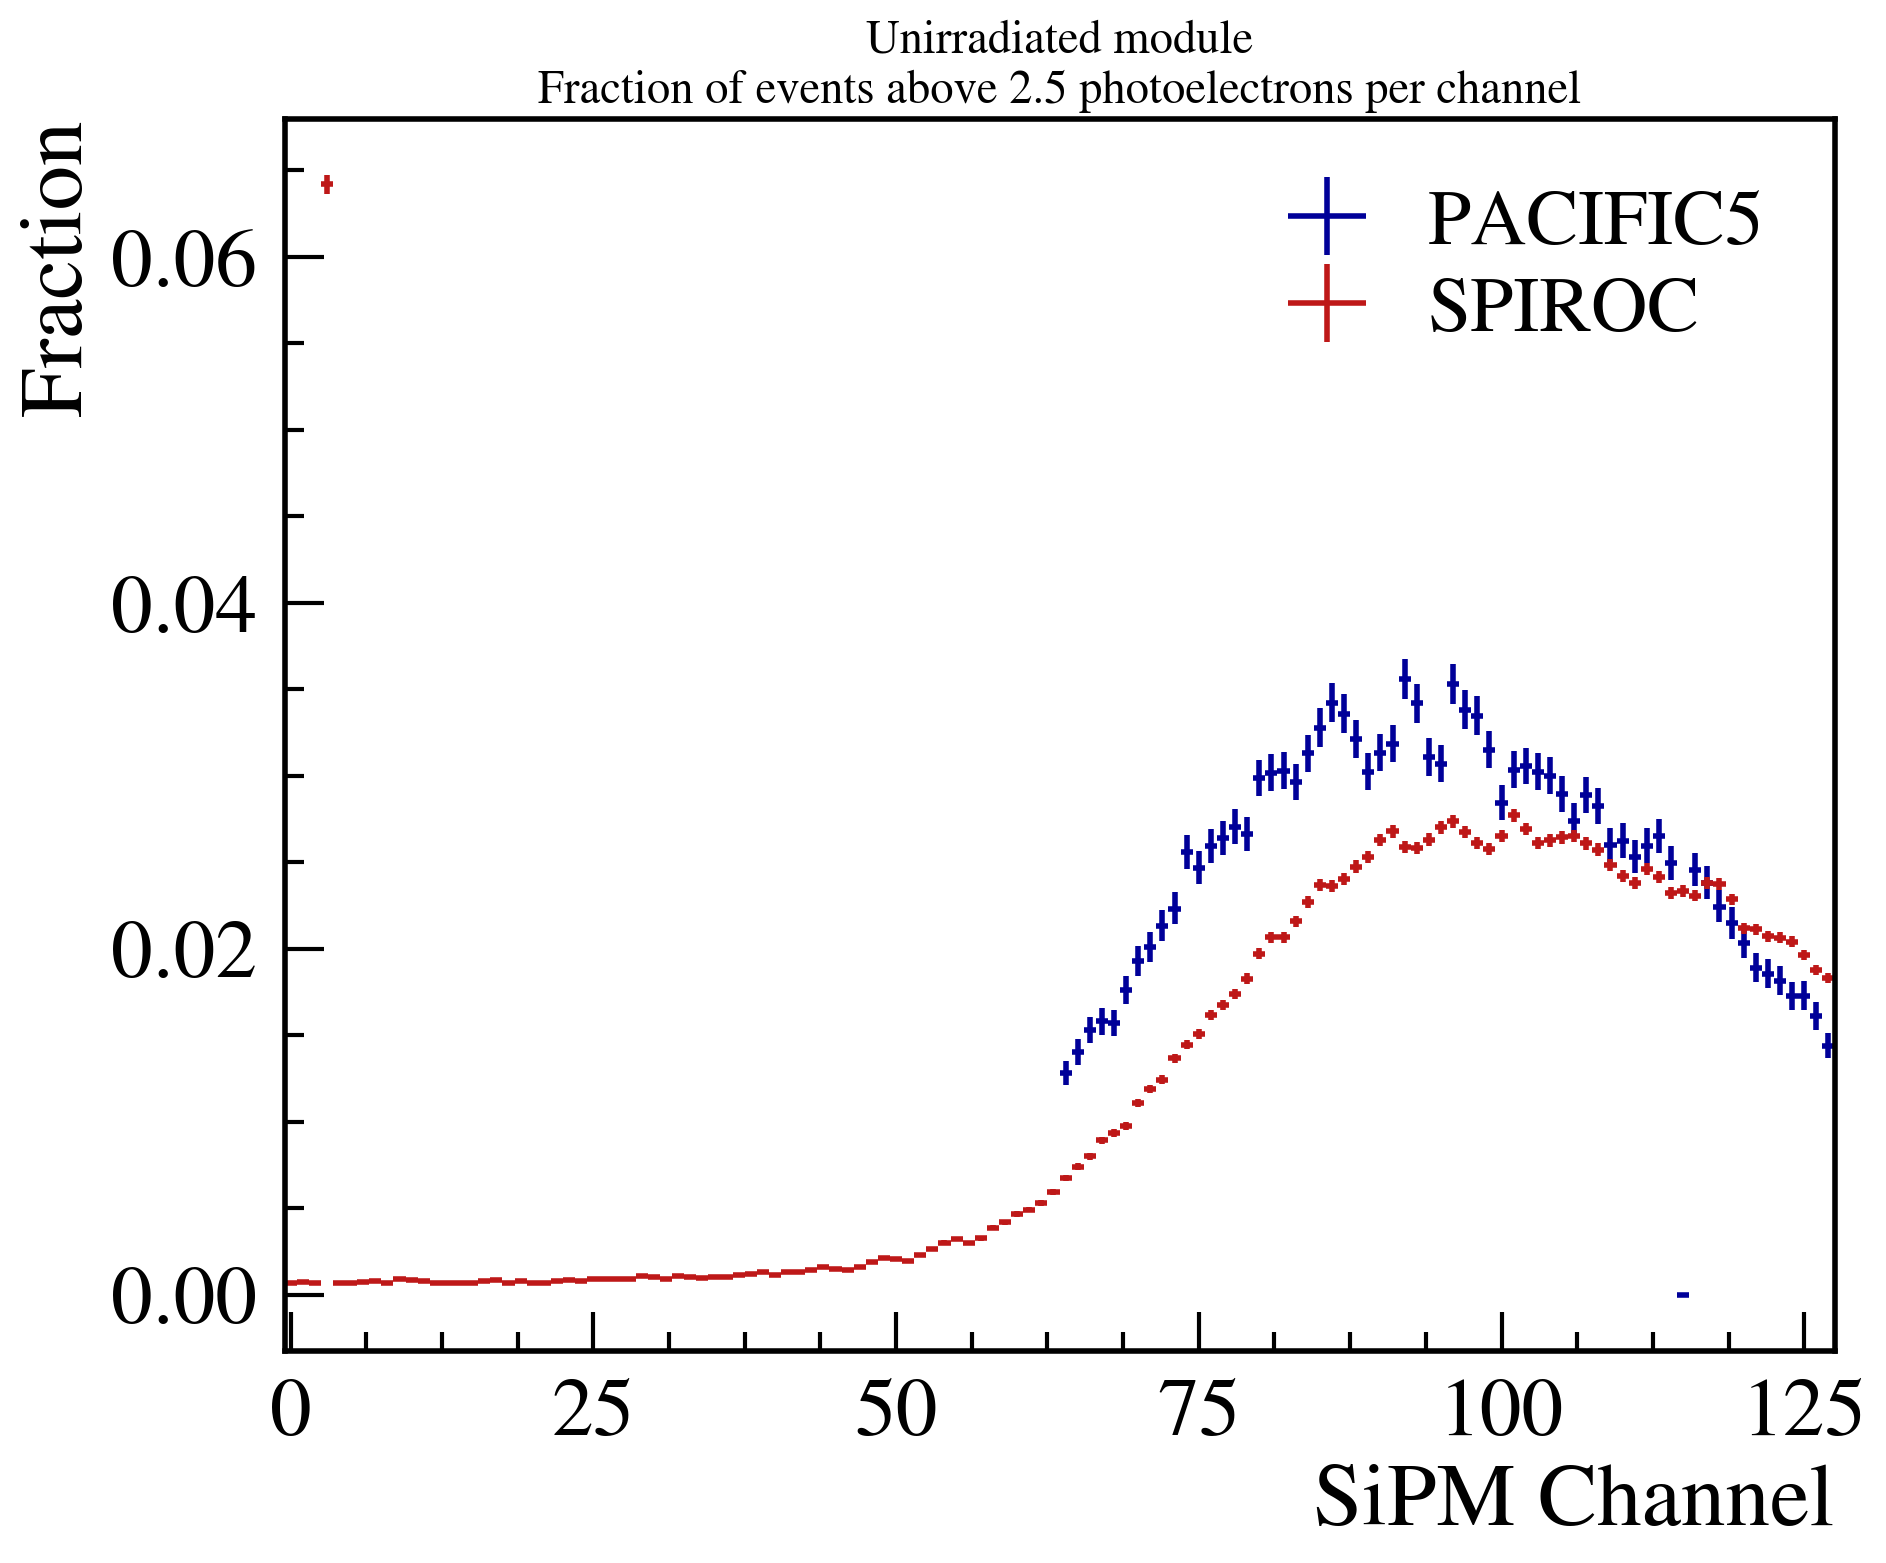

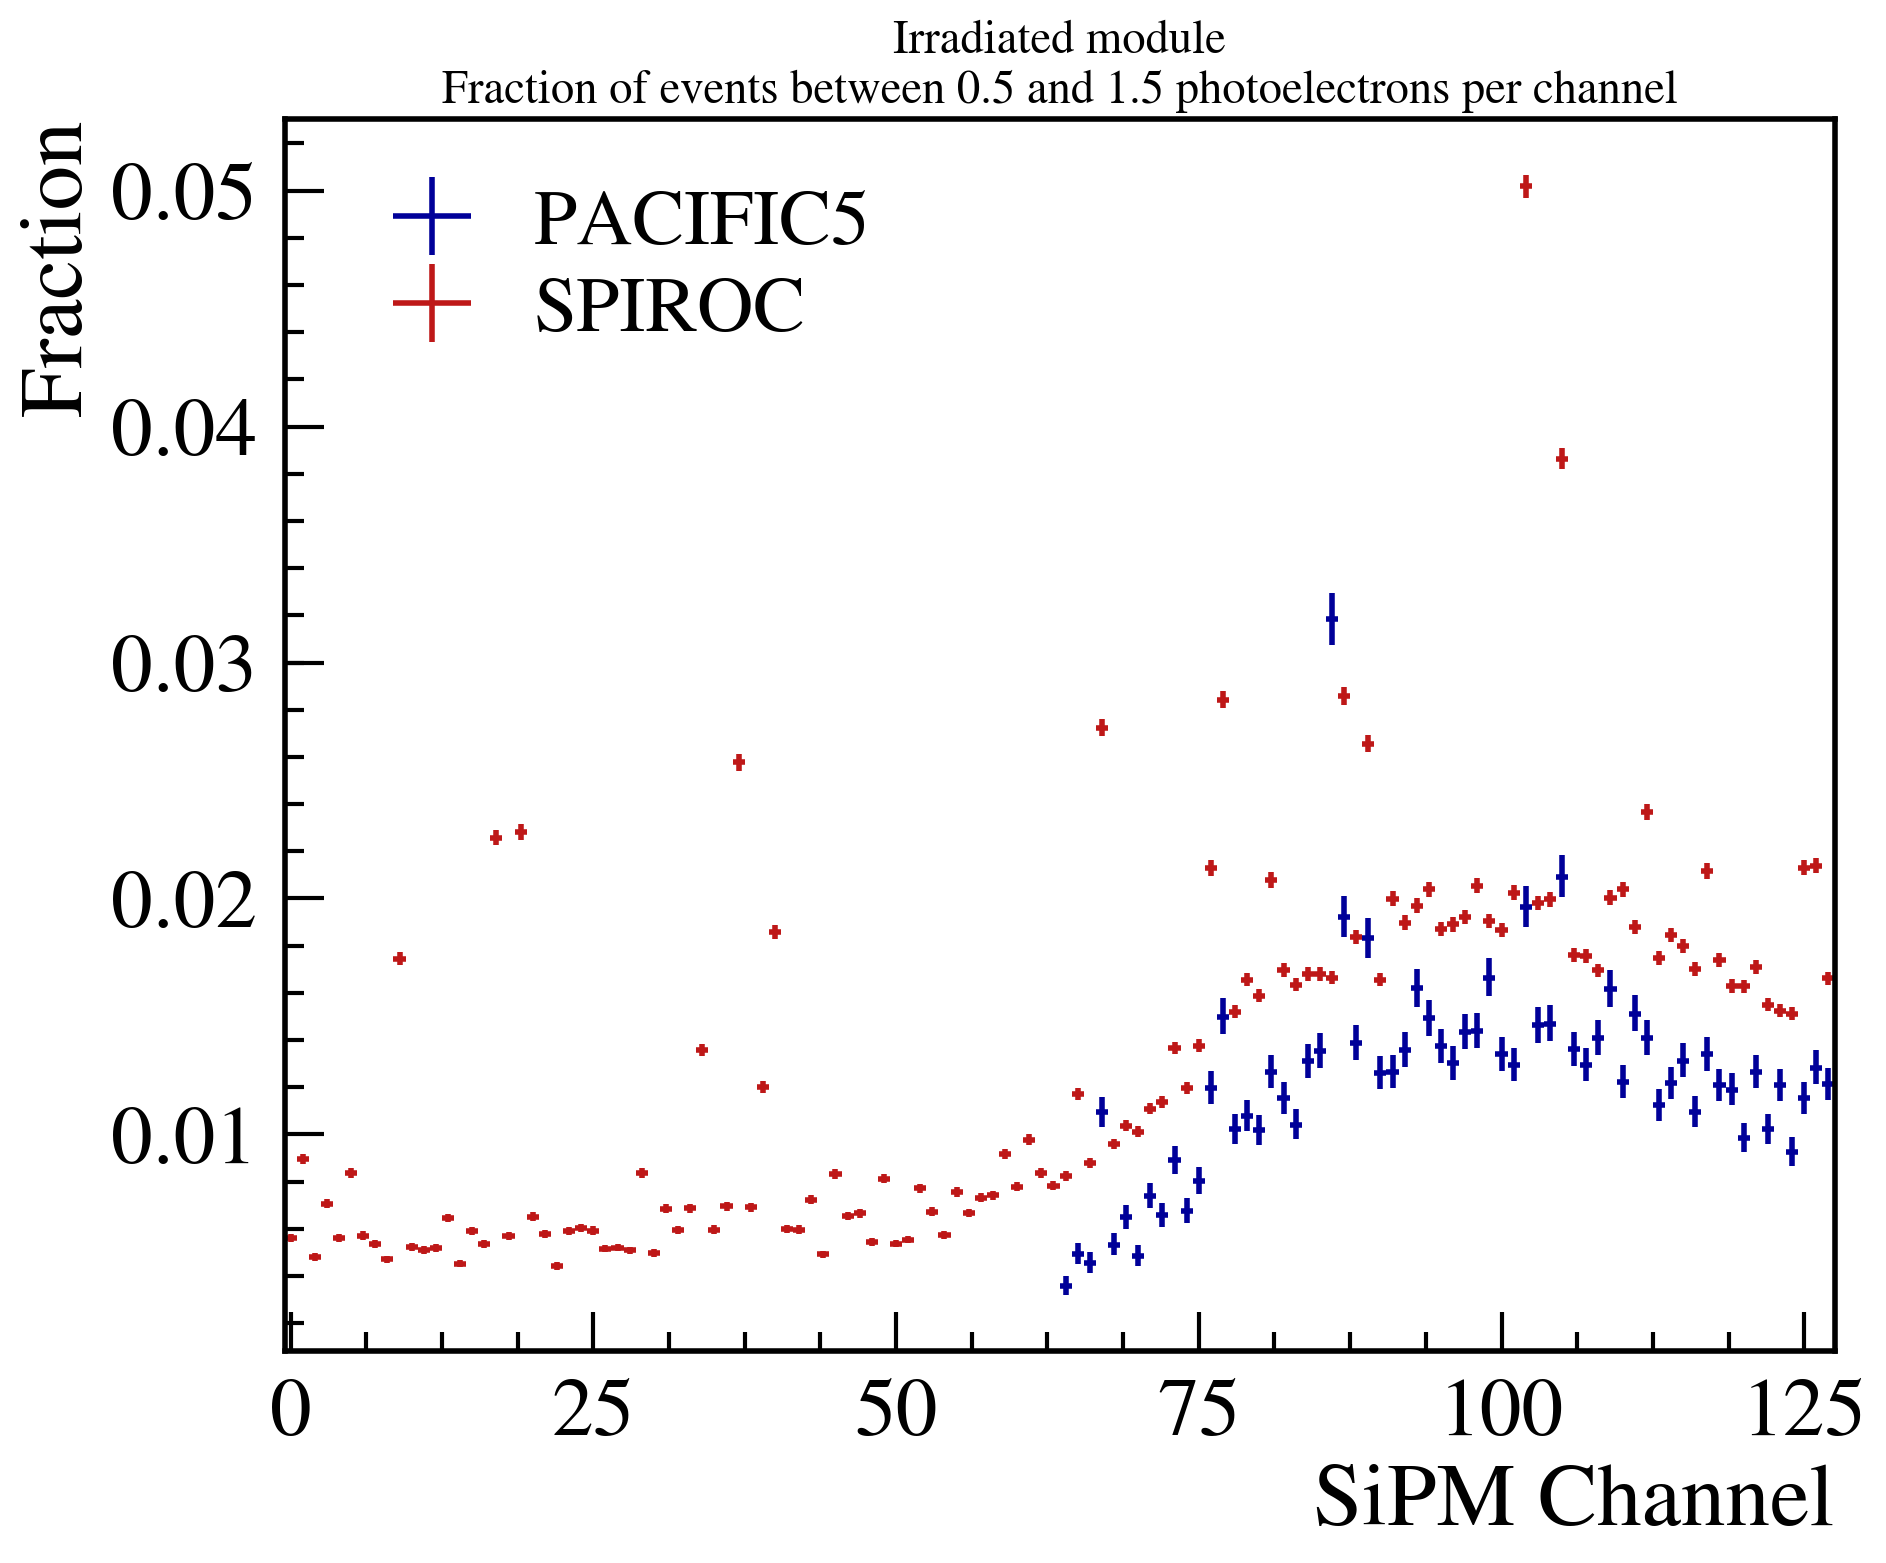

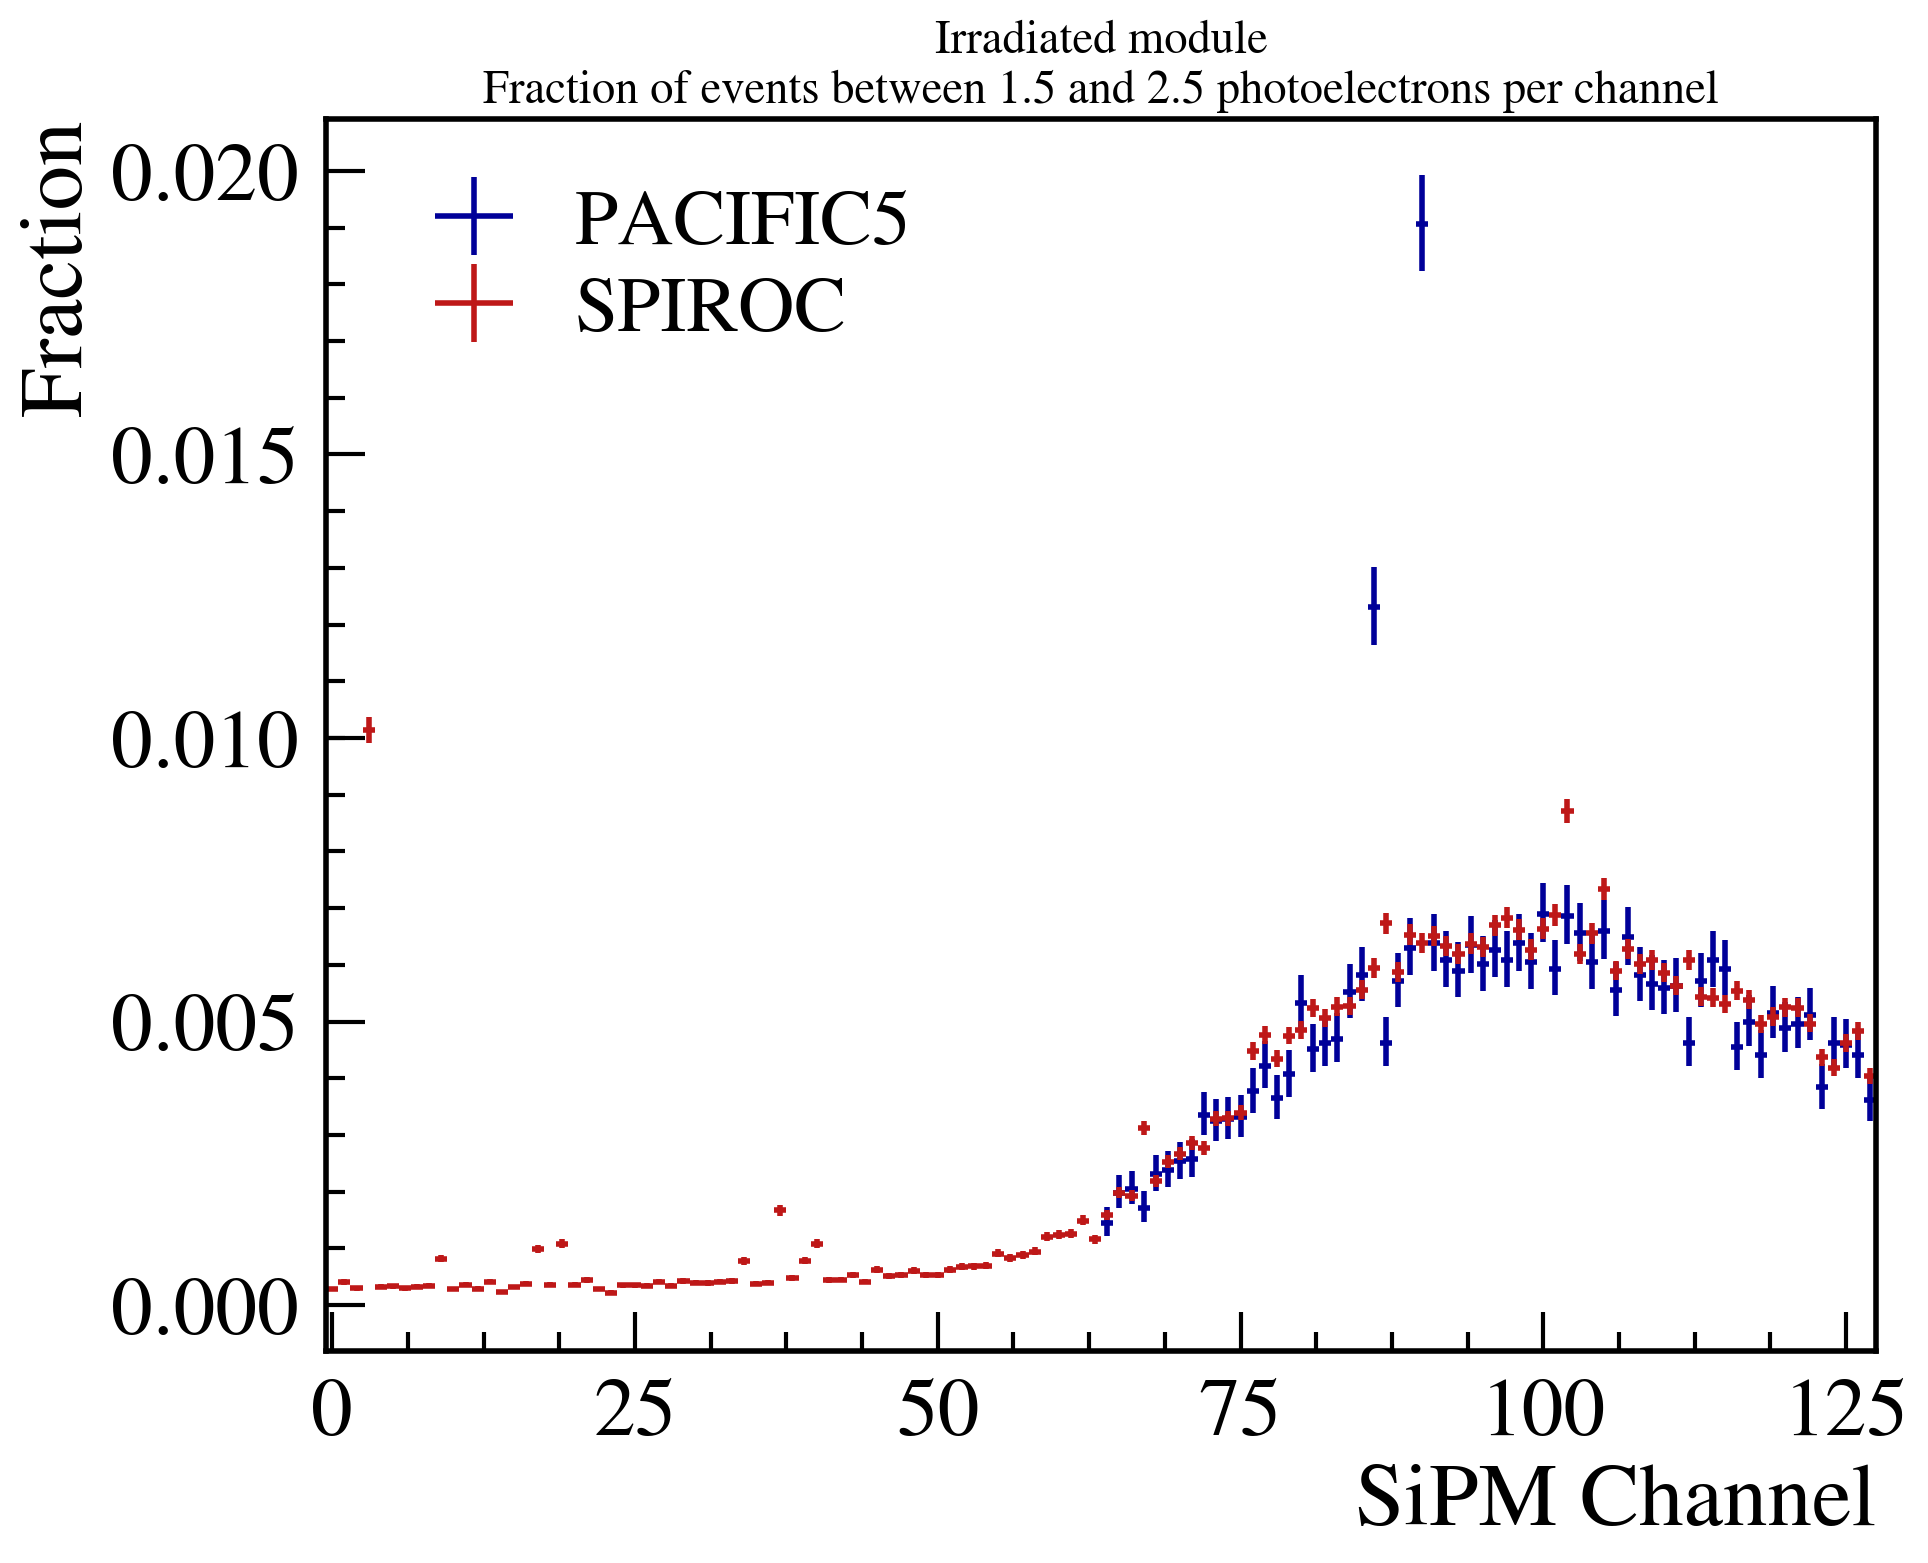

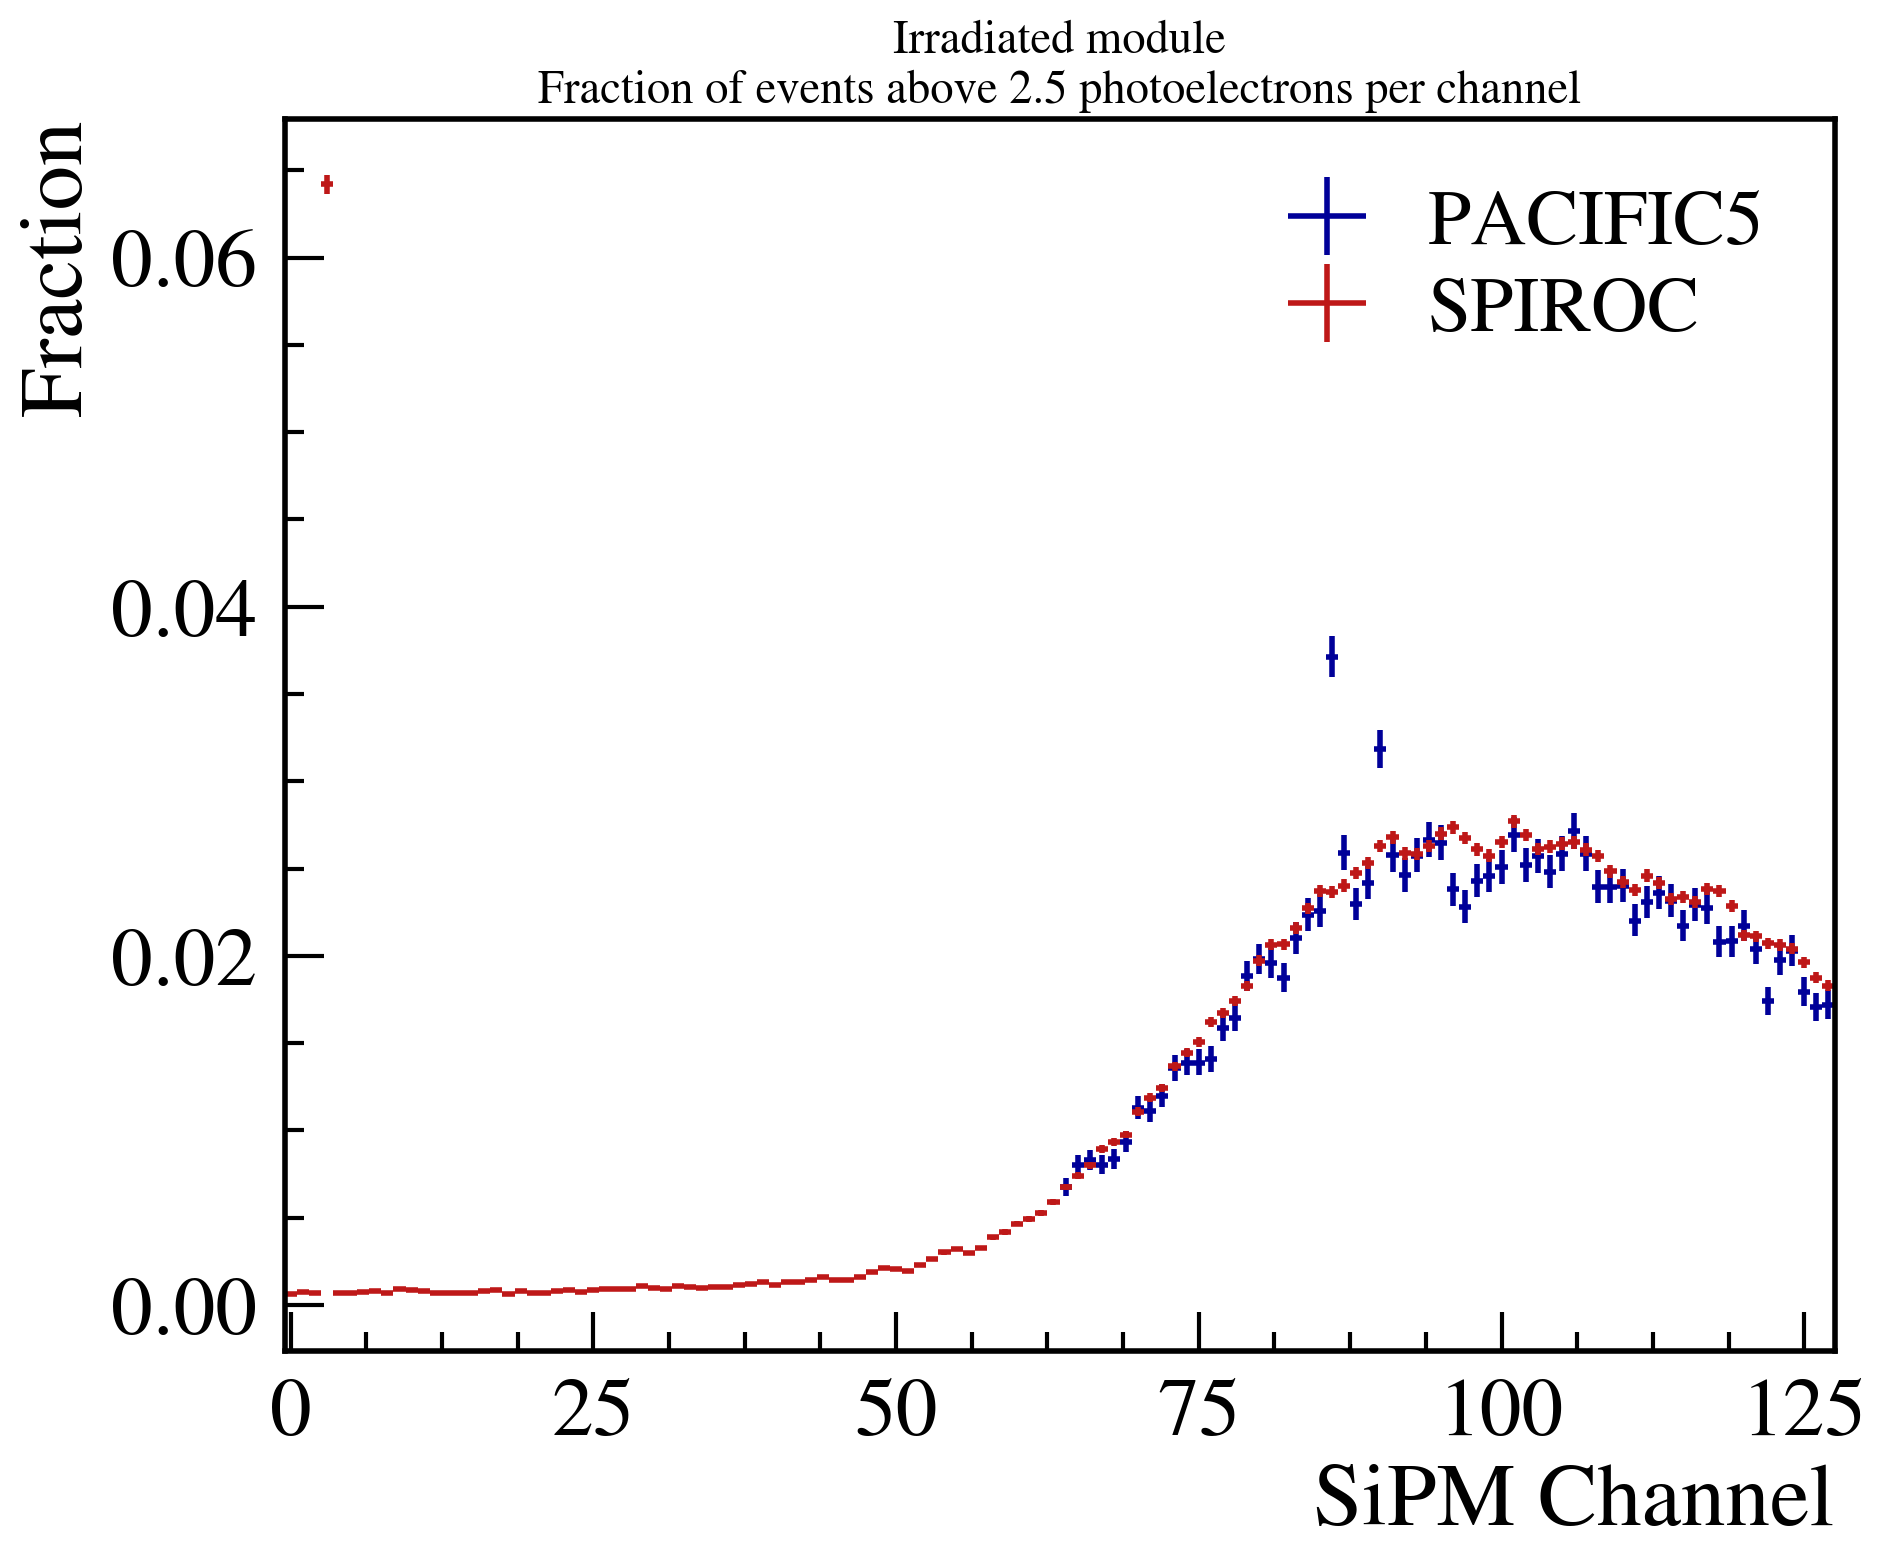

In [127]:
layer = 0
thresholds = [0.5, 1.5, 2.5]
for PACIFIC_sel, SPIROC_corr in [(DF_unirrad_sel, DF_SPIROC_unirrad), (DF_irrad_sel, DF_SPIROC_irrad)]:
    SPIROC_pacific_like = TB.SPIROC2Ths(SPIROC_corr[branches].values, Ths=thresholds)
    for th, color in izip([1,2,3], ["g", "r", "b"]):
        #PACIFIC
        ratio_pac, chs, errlow, errup = TB.overthreshold_vs_channels(
            PACIFIC_sel[["Ch_{}".format(ch) for ch in range(64)]], th, "equal")
        chs = np.asarray(chs)
        chs += 64  #Shift PACIFIC channels to match SPIROC channels
        dpl.errorbar(chs, ratio_pac, xerr=0.5, yerr=[errlow, errup], fmt=".", ms=0, label="PACIFIC5".format(th))
        
        #SPIROC
        ratio_spi, chs, errlow, errup = TB.overthreshold_vs_channels(pacific_like_data, th, "equal")
        dpl.errorbar(chs, ratio_spi, xerr=0.5, yerr=[errlow, errup], fmt=".", ms=0, label="SPIROC".format(th))
        
        title = "Unirradiated module" if layer==0 else "Irradiated module"
        if th<3:
            title += "\nFraction of events between {} and {} photoelectrons per channel".format(thresholds[th-1], 
                                                                                                thresholds[th])
        else:
            title += "\nFraction of events above {} photoelectrons per channel".format(thresholds[th-1])
        plt.title(title)
        dpl.xlabel("SiPM Channel")
        dpl.ylabel("Fraction")
        #plt.ylim(0, plt.ylim()[1])
        #if th==3 and layer==0:
        #    plt.ylim(0, 0.035)
        #if th==1 and layer==1:
        #    plt.ylim(0, 0.0075)
        #if th==2 and layer==1:
        #    plt.ylim(0, 0.006)
        #if th==3 and layer==1:
        #    plt.ylim(0, 0.025)
        plt.xlim(-0.5,127.5)
        plt.legend()

        plt.show()
        plt.close()
        
    layer += 1